<a href="https://colab.research.google.com/github/Nermine-Ou/PlanGeniusDesktopApp/blob/main/PlanGeniusFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Business Understanding

Project management is a field that consistently strives for efficiency, accuracy, and alignment with established standards such as the Project Management Body of Knowledge (PMBOK). Although there are several project management (PM) tools available, they often lack intelligent, real-time support systems that can enhance decision-making processes. This project aims to integrate AI-driven solutions into project management by leveraging PMBOK standards to provide personalized recommendations, optimize workflows, and address inefficiencies in existing project management tools.


#Initial Preparation

##Libraries Installation and Importation

In [ ]:
!pip install pdfplumber pdf2image pandas py2neo numpy PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.2/177.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 45.5 MB/s eta 0:00:00


In [ ]:
!pip install nltk spacy

In [ ]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 10.7 MB/s eta 0:00:00


In [ ]:
!pip install node2vec

In [ ]:
# Import necessary libraries
import os
import pdfplumber
import pandas as pd
import string
import re
from collections import Counter
import spacy
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Defining Paths

In [ ]:
# Define paths for the PDF, output CSVs, and text files
pdf_path = '/content/drive/My Drive/PMBOK 7th Edition (iBIMOne.com).pdf'
cleaned_csv = "/content/extracted_data_cleaned.csv"
texts_dir = '/content'  # Directory to save the text file
extracted_csv = os.path.join(texts_dir, 'extracted_data.csv')

#Data Extraction

##Image Extraction

In [ ]:
csv_output_file = "extracted_figures.csv"

In [ ]:
output_folder = "extracted_figures"  # Folder to save the extracted figures

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
# Using pdf2image to convert specific pages to images (specify page range)
images = convert_from_path(pdf_path, dpi=150, first_page=29, last_page=348)

# Iterate through each page and extract potential figures
for page_num, page in enumerate(images, start=29):
    # Convert the PIL image to a NumPy array (OpenCV format)
    open_cv_image = np.array(page)

    # Convert RGB to BGR (for OpenCV compatibility)
    open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_RGB2BGR)

    # Convert image to grayscale
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to detect figures (better for variable lighting)
    thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours from the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over contours and save bounding boxes as separate images
    for i, contour in enumerate(contours):
        # Get the bounding box for the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Ignore very small areas to avoid noise (adjust the threshold as needed)
        if w * h > 15000:  # Adjust the size threshold based on your needs
            # Extract the figure region
            figure = open_cv_image[y:y + h, x:x + w]

            # Save the figure as an image file
            output_filename = os.path.join(output_folder, f"page_{page_num}_figure_{i + 1}.png")
            cv2.imwrite(output_filename, figure)
            print(f"Extracted figure saved to: {output_filename}")

print("Figure extraction completed!")

Extracted figure saved to: extracted_figures/page_30_figure_998.png
Extracted figure saved to: extracted_figures/page_34_figure_1236.png
Extracted figure saved to: extracted_figures/page_36_figure_513.png
Extracted figure saved to: extracted_figures/page_37_figure_494.png
Extracted figure saved to: extracted_figures/page_38_figure_100.png
Extracted figure saved to: extracted_figures/page_46_figure_97.png
Extracted figure saved to: extracted_figures/page_48_figure_1583.png
Extracted figure saved to: extracted_figures/page_49_figure_132.png
Extracted figure saved to: extracted_figures/page_51_figure_115.png
Extracted figure saved to: extracted_figures/page_55_figure_363.png
Extracted figure saved to: extracted_figures/page_58_figure_411.png
Extracted figure saved to: extracted_figures/page_61_figure_1284.png
Extracted figure saved to: extracted_figures/page_64_figure_1117.png
Extracted figure saved to: extracted_figures/page_67_figure_1080.png
Extracted figure saved to: extracted_figures

In [ ]:
# Get the list of all files in the output folder
files = os.listdir(output_folder)

# Prepare data for CSV
data = []

# Iterate over all files to collect information
for file_name in files:
    if file_name.endswith('.png'):  # Only include PNG files
        file_path = os.path.join(output_folder, file_name)
        data.append({
            'Figure/Table Title': file_name.replace(".png", ""),
            'Description': '',  # You can leave it empty for now or add a description later
            'Image Path': file_path
        })

# Convert data to a DataFrame and save to a CSV file
df = pd.DataFrame(data)
df.to_csv(csv_output_file, index=False, encoding='utf-8-sig')

print(f"CSV with figures information saved to: {csv_output_file}")


CSV with figures information saved to: extracted_figures.csv


##Text Extraction from the PDF Document

In [ ]:
# List to store the extracted data
data = []

In [ ]:

pdf_text = ''  # To concatenate all page text

with pdfplumber.open(pdf_path) as pdf:
    for page_num in range(29, 348):  # Page 30 to 348
        if page_num < len(pdf.pages):
            page = pdf.pages[page_num]
            page_text = page.extract_text() if page.extract_text() else ""
            pdf_text += page_text.strip() + "\n"  # Concatenate text from each page

            # Append page number and text to the data list
            data.append({'Page Number': page_num + 1, 'Page Text': page_text.strip()})

# Step 2: Save the concatenated text to a .txt file
with open('/content/extracted_text.txt', 'w', encoding='utf-8') as text_file:
    text_file.write(pdf_text)

# Step 3: Save the data to a CSV file
df = pd.DataFrame(data)
df.to_csv(extracted_csv, index=False)

print(f"Data extraction completed. The extracted data has been saved to: /content/extracted_text.txt")
print(f"The extracted data CSV has been saved to: {extracted_csv}")


Data extraction completed. The extracted data has been saved to: /content/extracted_text.txt
The extracted data CSV has been saved to: /content/extracted_data.csv


In [ ]:
# Load the extracted text
with open('/content/extracted_text.txt', 'r', encoding='utf-8') as file:
    raw_text = file.read()

# Display a small sample of the raw text
print(raw_text[:1000])  # Display the first 1000 characters for review

1
Introduction
The Standard for Project Management identifies project management principles that guide the
behaviors and actions of project professionals and other stakeholders who work on or are engaged
with projects.
This introductory section describes the purpose of this standard, defines key terms and
concepts, and identifies the audience for the standard.
The Standard for Project Management consists of the following sections:
▶ Section 1 Introduction
▶ Section 2 A System for Value Delivery
▶ Section 3 Project Management Principles
1.1 PURPOSE OF THE STANDARD FOR PROJECT MANAGEMENT
The Standard for Project Management provides a basis for understanding project management
and how it enables intended outcomes. This standard applies regardless of industry, location, size,
or delivery approach, for example, predictive, hybrid, or adaptive. It describes the system within
which projects operate, including governance, possible functions, the project environment, and
considerations for the 

# Data Preprocessing

##Text Preprocessing

**1. Removing Footers**

In [ ]:
import re

# Function to remove footers based on specific patterns
def remove_footer(text):
    footer_pattern = r'(?i)(pmi seventh edition \w+ \d{4}|the standard for project management|section \d+.*|^\s*\d+\s*$)'
    lines = text.splitlines()
    cleaned_lines = [line for line in lines if not re.search(footer_pattern, line)]
    return "\n".join(cleaned_lines).strip()

# Apply the function to the raw text
cleaned_text = remove_footer(raw_text)
print(cleaned_text[:1000])  # Display the first 1000 characters for review

df['Cleaned Page Text'] = df['Page Text'].apply(remove_footer)
df.to_csv(cleaned_csv, index=False)

Introduction
behaviors and actions of project professionals and other stakeholders who work on or are engaged
with projects.
This introductory section describes the purpose of this standard, defines key terms and
concepts, and identifies the audience for the standard.
and how it enables intended outcomes. This standard applies regardless of industry, location, size,
or delivery approach, for example, predictive, hybrid, or adaptive. It describes the system within
which projects operate, including governance, possible functions, the project environment, and
considerations for the relationship between project management and product management.
1.2 KEY TERMS AND CONCEPTS
expect projects to deliver outcomes in addition to outputs and artifacts. Project managers are
expected to deliver projects that create value for the organization and stakeholders within the
organization’s system for value delivery. The following terms are defined to provide context for the
content in this standard.
▶ Out

**2. Removing Punctuation**

In [ ]:
import string

# Function to remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# Apply the function to the cleaned text
cleaned_text = remove_punctuation(cleaned_text)
print(cleaned_text[:1000])  # Display the first 1000 characters for review

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(remove_punctuation)
df.to_csv(cleaned_csv, index=False)


Introduction
behaviors and actions of project professionals and other stakeholders who work on or are engaged
with projects
This introductory section describes the purpose of this standard defines key terms and
concepts and identifies the audience for the standard
and how it enables intended outcomes This standard applies regardless of industry location size
or delivery approach for example predictive hybrid or adaptive It describes the system within
which projects operate including governance possible functions the project environment and
considerations for the relationship between project management and product management
12 KEY TERMS AND CONCEPTS
expect projects to deliver outcomes in addition to outputs and artifacts Project managers are
expected to deliver projects that create value for the organization and stakeholders within the
organization’s system for value delivery The following terms are defined to provide context for the
content in this standard
▶ Outcome An end result or 

**3. Removing Numbers**

In [ ]:
# Function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Apply the function to the cleaned text
cleaned_text = remove_numbers(cleaned_text)
print(cleaned_text[:1000])  # Display the first 1000 characters for review

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(remove_numbers)
df.to_csv(cleaned_csv, index=False)



Introduction
behaviors and actions of project professionals and other stakeholders who work on or are engaged
with projects
This introductory section describes the purpose of this standard defines key terms and
concepts and identifies the audience for the standard
and how it enables intended outcomes This standard applies regardless of industry location size
or delivery approach for example predictive hybrid or adaptive It describes the system within
which projects operate including governance possible functions the project environment and
considerations for the relationship between project management and product management
 KEY TERMS AND CONCEPTS
expect projects to deliver outcomes in addition to outputs and artifacts Project managers are
expected to deliver projects that create value for the organization and stakeholders within the
organization’s system for value delivery The following terms are defined to provide context for the
content in this standard
▶ Outcome An end result or co

**4. Removing Line Breaks And WhiteSpace**

In [ ]:
# Function to remove line breaks and excessive whitespace
def remove_line_breaks_whitespace(text):
    # Replace line breaks with a single space
    text = text.replace('\n', ' ')
    # Remove excessive whitespace (more than one space in a row)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply the function to the cleaned text
cleaned_text = remove_line_breaks_whitespace(cleaned_text)
print(cleaned_text[:1000])  # Display the first 1000 characters for review

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(remove_line_breaks_whitespace)
df.to_csv(cleaned_csv, index=False)

Introduction behaviors and actions of project professionals and other stakeholders who work on or are engaged with projects This introductory section describes the purpose of this standard defines key terms and concepts and identifies the audience for the standard and how it enables intended outcomes This standard applies regardless of industry location size or delivery approach for example predictive hybrid or adaptive It describes the system within which projects operate including governance possible functions the project environment and considerations for the relationship between project management and product management KEY TERMS AND CONCEPTS expect projects to deliver outcomes in addition to outputs and artifacts Project managers are expected to deliver projects that create value for the organization and stakeholders within the organization’s system for value delivery The following terms are defined to provide context for the content in this standard ▶ Outcome An end result or con

**5. Removing Special Chracters**

In [ ]:
# Function to remove special characters
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)

# Apply the function to the cleaned text
cleaned_text = remove_special_characters(cleaned_text)
print(cleaned_text[:1000])  # Display the first 1000 characters for review

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(remove_special_characters)
df.to_csv(cleaned_csv, index=False)

Introduction behaviors and actions of project professionals and other stakeholders who work on or are engaged with projects This introductory section describes the purpose of this standard defines key terms and concepts and identifies the audience for the standard and how it enables intended outcomes This standard applies regardless of industry location size or delivery approach for example predictive hybrid or adaptive It describes the system within which projects operate including governance possible functions the project environment and considerations for the relationship between project management and product management KEY TERMS AND CONCEPTS expect projects to deliver outcomes in addition to outputs and artifacts Project managers are expected to deliver projects that create value for the organization and stakeholders within the organizations system for value delivery The following terms are defined to provide context for the content in this standard  Outcome An end result or conse

**6. Lowercasing**

In [ ]:
# Function to convert text to lowercase
def to_lowercase(text):
    return text.lower()

# Apply the function to the cleaned text
cleaned_text = to_lowercase(cleaned_text)
print(cleaned_text[:10000])  # Display the first 10000 characters for review


df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(to_lowercase)
df.to_csv(cleaned_csv, index=False)

introduction behaviors and actions of project professionals and other stakeholders who work on or are engaged with projects this introductory section describes the purpose of this standard defines key terms and concepts and identifies the audience for the standard and how it enables intended outcomes this standard applies regardless of industry location size or delivery approach for example predictive hybrid or adaptive it describes the system within which projects operate including governance possible functions the project environment and considerations for the relationship between project management and product management key terms and concepts expect projects to deliver outcomes in addition to outputs and artifacts project managers are expected to deliver projects that create value for the organization and stakeholders within the organizations system for value delivery the following terms are defined to provide context for the content in this standard  outcome an end result or conse

**7. Spacy Tokenization → Stop Words Removal → Lemmatization**

*a. Functions declaration*

- Tokenization

In [ ]:
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Function for tokenization
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

# Apply the tokenization function
tokens = tokenize(cleaned_text)
print(tokens[:50])  # Display the first 50 tokens for review

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(tokenize)
df.to_csv(cleaned_csv, index=False)

['introduction', 'behaviors', 'and', 'actions', 'of', 'project', 'professionals', 'and', 'other', 'stakeholders', 'who', 'work', 'on', 'or', 'are', 'engaged', 'with', 'projects', 'this', 'introductory', 'section', 'describes', 'the', 'purpose', 'of', 'this', 'standard', 'defines', 'key', 'terms', 'and', 'concepts', 'and', 'identifies', 'the', 'audience', 'for', 'the', 'standard', 'and', 'how', 'it', 'enables', 'intended', 'outcomes', 'this', 'standard', 'applies', 'regardless', 'of']


- Stop Words Removal

In [ ]:
# Function to remove stop words
def remove_stop_words(tokens):
    filtered_tokens = [token for token in tokens if not nlp.vocab[token].is_stop]
    return filtered_tokens

# Apply the stop words removal function
tokens_no_stopwords = remove_stop_words(tokens)
print(tokens_no_stopwords[:50])  # Display the first 50 tokens after stop words removal

df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(remove_stop_words)
df.to_csv(cleaned_csv, index=False)

['introduction', 'behaviors', 'actions', 'project', 'professionals', 'stakeholders', 'work', 'engaged', 'projects', 'introductory', 'section', 'describes', 'purpose', 'standard', 'defines', 'key', 'terms', 'concepts', 'identifies', 'audience', 'standard', 'enables', 'intended', 'outcomes', 'standard', 'applies', 'regardless', 'industry', 'location', 'size', 'delivery', 'approach', 'example', 'predictive', 'hybrid', 'adaptive', 'describes', 'system', 'projects', 'operate', 'including', 'governance', 'possible', 'functions', 'project', 'environment', 'considerations', 'relationship', 'project', 'management']


- Lemmatization

In [ ]:
# Function for lemmatization and joining tokens
def lemmatize(tokens):
    # Lemmatize the tokens
    lemmatized_tokens = [token.lemma_ for token in nlp(' '.join(tokens))]
    # Rejoin the lemmatized tokens into a single string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Apply the lemmatization function to the preprocessed tokens
lemmatized_text = lemmatize(tokens_no_stopwords)
print(lemmatized_text[:1000])  # Display the first 1000 characters for review

# Apply the modified lemmatization function to each row in the DataFrame
df['Cleaned Page Text'] = df['Cleaned Page Text'].apply(lemmatize)

# Save the updated DataFrame to the CSV file
df.to_csv(cleaned_csv, index=False)

introduction behavior action project professional stakeholder work engage project introductory section describe purpose standard define key term concept identify audience standard enable intend outcomes standard apply regardless industry location size delivery approach example predictive hybrid adaptive describe system project operate include governance possible function project environment consideration relationship project management product management key term concept expect project deliver outcome addition output artifact project manager expect deliver project create value organization stakeholder organization system value delivery follow term define provide context content standard    outcome end result consequence process project outcome include output artifact broad intent focus benefit value project undertake deliver    portfolio project programs subsidiary portfolio operation manage group achieve strategic objective    product artifact produce quantifiable end item component i

##Knwoledge Retrieval

### Term Extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import spacy

# Load spaCy model for semantic similarity
nlp = spacy.load('en_core_web_sm')

# Initialize the TF-IDF Vectorizer with stricter min_df and max_df
tfidf_vectorizer = TfidfVectorizer(max_features=200, max_df=0.8, min_df=0.02)  # Stricter thresholds

# Fit and transform the text data at a lower threshold (paragraph level or subsection level if possible)
text_data = df['Cleaned Page Text'].tolist()  # Assuming you have paragraph or subsection text data here
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Save the TF-IDF results
tfidf_df.to_csv('/content/refined_term_extraction_tfidf.csv', index=False)

# Step 2: Use the new thresholds to select top N important terms
top_n = 100  # Consider only the top 100 terms before filtering
term_importance = tfidf_df.mean().sort_values(ascending=False)
top_terms = term_importance.head(top_n)

# Manual Stopwords or General Terms Filtering
custom_stopwords = ["example", "document", "service", "new", "support", "function"]  # Add more irrelevant terms

# Filter out custom stopwords
filtered_terms = [term for term in top_terms.index if term not in custom_stopwords]

# Optional: Filter based on semantic similarity to key domain concepts (e.g., "project management", "risk")
domain_concepts = ['project', 'management', 'risk', 'team', 'performance']

def is_domain_relevant(term, domain_concepts, threshold=0.75):  # Tighter threshold of 0.75
    term_doc = nlp(term)
    for concept in domain_concepts:
        concept_doc = nlp(concept)
        if term_doc.similarity(concept_doc) > threshold:
            return True
    return False

# Filter out terms that are not semantically related to domain concepts
terms = [term for term in filtered_terms if is_domain_relevant(term, domain_concepts)]

# Cap the list at 30 terms
terms = terms[:40]

# Display refined terms
print("Refined Important Terms (40 or fewer):")
print(terms)

# Save the refined terms
terms_df = pd.DataFrame(terms, columns=['Term'])
terms_df.to_csv('/content/refined_key_terms.csv', index=False)


<ipython-input-21-49968dd89ded>:39: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  if term_doc.similarity(concept_doc) > threshold:


Refined Important Terms (40 or fewer):
['team', 'work', 'management', 'performance', 'product', 'value', 'process', 'plan', 'organization', 'risk', 'domain', 'delivery', 'information', 'activity', 'development', 'environment', 'system', 'requirement', 'cycle', 'method', 'model', 'life', 'figure', 'business', 'measure', 'program', 'quality', 'member', 'customer', 'schedule', 'leadership', 'impact', 'resource', 'phase', 'analysis', 'decision', 'benefit', 'scope', 'communication', 'artifact']


###Synonyms and defintions

In [ ]:
import pandas as pd
import re
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize
from transformers import pipeline
import nltk

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import requests
from nltk.corpus import wordnet
import nltk
import pandas as pd

# Ensure NLTK data is available
nltk.download('wordnet')
nltk.download('punkt')

# List of terms to extract definitions and synonyms for
terms = [
    'team', 'work', 'management', 'performance', 'product', 'value', 'process', 'plan',
    'organization', 'risk', 'domain', 'delivery', 'information', 'activity', 'development',
    'environment', 'system', 'requirement', 'cycle', 'method', 'model', 'life', 'figure',
    'business', 'measure', 'program', 'quality', 'member', 'customer', 'schedule', 'leadership',
    'impact', 'resource', 'phase', 'analysis', 'decision', 'benefit', 'scope', 'communication', 'artifact'
]

# Define custom definitions for these project management terms (could be extended)
custom_definitions = {
    'team': 'A group of individuals working together to achieve a common goal.',
    'work': 'Physical or mental effort performed to achieve a result.',
    'management': 'The process of planning, organizing, and coordinating resources to achieve goals.',
    'performance': 'The act of executing tasks, demonstrating capability, or achieving objectives.',
    'product': 'An item or service created or produced for sale or consumption.',
    'value': 'The importance or worth of something in terms of its usefulness or utility.',
    'process': 'A series of actions or steps taken to achieve a particular outcome.',
    'plan': 'A detailed proposal for doing or achieving something.',
    'organization': 'A structured group of people working together to achieve a goal.',
    'risk': 'The possibility of a negative outcome affecting project objectives.',
    'domain': 'The field or area in which a particular project operates.',
    'delivery': 'The process of handing over the completed product or service to the customer.',
    'information': 'Data that is processed or organized to have meaning.',
    'activity': 'A task or action performed as part of the project.',
    'development': 'The process of improving or creating a product or service.',
    'environment': 'The surroundings or conditions that affect the project.',
    'system': 'A set of interconnected elements working together as a whole.',
    'requirement': 'A condition or capability needed to fulfill a project objective.',
    'cycle': 'A series of stages or processes repeated in a sequence.',
    'method': 'A systematic approach or procedure for performing a task.',
    'model': 'A simplified representation of a system used for analysis or prediction.',
    'life': 'The stages or phases of a product or project from initiation to completion.',
    'figure': 'A representation or illustration used for clarification or visualization.',
    'business': 'The organization or activities involved in producing goods or services.',
    'measure': 'A method of assessing or quantifying something.',
    'program': 'A set of related projects managed together to achieve a common objective.',
    'quality': 'The degree to which a product or service meets requirements and expectations.',
    'member': 'An individual who is part of a group or team.',
    'customer': 'An individual or organization that receives or purchases a product or service.',
    'schedule': 'A plan that outlines when specific project tasks will be completed.',
    'leadership': 'The ability to guide and influence a group towards achieving goals.',
    'impact': 'The effect or influence of an action or event on the project.',
    'resource': 'The people, equipment, and materials needed to complete project tasks.',
    'phase': 'A distinct stage in the lifecycle of a project.',
    'analysis': 'The process of examining and interpreting information to understand or solve a problem.',
    'decision': 'A conclusion or resolution reached after considering alternatives.',
    'benefit': 'The positive outcome or advantage gained from a project or action.',
    'scope': 'The boundaries and deliverables of a project or task.',
    'communication': 'The process of sharing information between individuals or groups.',
    'artifact': 'A tangible or intangible product produced during a project.'
}

# Function to find synonyms using WordNet
def find_synonyms_wordnet(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().replace('_', ' '))  # Add the lemma to the synonyms set
    return ', '.join(synonyms) if synonyms else 'No synonyms found'

# Placeholder for terms, definitions, and synonyms
term_definitions = []

# Iterate through each term to extract short definitions and synonyms
for term in terms:
    # Get custom definition from the predefined dictionary
    definition = custom_definitions.get(term, 'No definition found')

    # Get synonyms from WordNet
    synonyms = find_synonyms_wordnet(term)

    # Append the term, definition, and synonyms to the term_definitions list
    term_definitions.append({
        'Term': term,
        'Definition': definition,
        'Synonyms': synonyms
    })

# Convert the list to a DataFrame and save to CSV
definition_df = pd.DataFrame(term_definitions)
file_path = 'project_management_definitions_and_synonyms.csv'
definition_df.to_csv(file_path, index=False)

print(f"Term definitions and synonyms saved to: {file_path}")

# Display the first few rows of the DataFrame to review
print(definition_df.head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Term definitions and synonyms saved to: project_management_definitions_and_synonyms.csv
          Term                                         Definition  \
0         team  A group of individuals working together to ach...   
1         work  Physical or mental effort performed to achieve...   
2   management  The process of planning, organizing, and coord...   
3  performance  The act of executing tasks, demonstrating capa...   
4      product  An item or service created or produced for sal...   

                                            Synonyms  
0                               team up, squad, team  
1  operate, workplace, exercise, act upon, do wor...  
2                              direction, management  
3  functioning, performance, carrying into action...  
4  ware, mathematical product, product, productio...  


###Extracting Main Concepts (Categories)
We will need it to build hiearchial relationships in the long run

In [ ]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy

# Load SpaCy model for semantic similarity
nlp = spacy.load('en_core_web_md')

# List of categories and their representative keywords
categories = {
    "Risk Management": ["risk", "impact", "uncertainty"],
    "Team Management": ["team", "leadership", "member", "communication"],
    "Planning and Execution": ["plan", "schedule", "process", "deliverable", "activity", "development"],
    "Quality and Program Management": ["quality", "program", "performance", "benefit"],
    "Resource Management": ["resource", "decision", "phase", "analysis"],
    "Value and Outcome": ["value", "outcome", "artifact"],
    "Knowledge and Information": ["knowledge", "information", "guide", "behavior", "skill"],
    "Business and System": ["business", "system", "cycle", "figure", "model", "method"]
}

# Function to map terms to categories based on keywords
def map_term_to_category(term, categories):
    for category, keywords in categories.items():
        if any(keyword in term for keyword in keywords):
            return category
    return 'Uncategorized'

# Apply the categorization
term_category_mapping = {term: map_term_to_category(term, categories) for term in terms}

# Refine uncategorized terms by finding their best-fit category using semantic similarity
def refine_uncategorized_terms(uncategorized_terms, categories):
    refined_terms = {}
    for term in uncategorized_terms:
        term_doc = nlp(term)
        best_category = None
        best_similarity = 0.0
        for category, keywords in categories.items():
            category_similarity = max([term_doc.similarity(nlp(keyword)) for keyword in keywords])
            if category_similarity > best_similarity:
                best_similarity = category_similarity
                best_category = category
        # Reassign term to the best matching category if similarity is sufficient
        refined_terms[term] = best_category if best_similarity > 0.5 else 'Uncategorized'
    return refined_terms

# Get the uncategorized terms
uncategorized_terms = [term for term, category in term_category_mapping.items() if category == 'Uncategorized']

# Refine the uncategorized terms and reassign them
refined_uncategorized = refine_uncategorized_terms(uncategorized_terms, categories)

# Merge refined terms back into the main mapping
final_concept_mapping = {**term_category_mapping, **refined_uncategorized}

# Remove 'Miscellaneous' terms
final_concept_mapping = {term: category for term, category in final_concept_mapping.items() if category != 'Uncategorized'}

# Convert to DataFrame for display
concept_df = pd.DataFrame(list(final_concept_mapping.items()), columns=['Term', 'Concept'])

# Display the updated concepts
print(concept_df)

# Save the refined concept mapping to a CSV file
concept_df.to_csv('/content/final_concept_mapping_refined.csv', index=False)


             Term                         Concept
0            team                 Team Management
1            work             Business and System
2      management          Planning and Execution
3     performance  Quality and Program Management
4         product  Quality and Program Management
5           value               Value and Outcome
6         process          Planning and Execution
7            plan          Planning and Execution
8    organization                 Team Management
9            risk                 Risk Management
10         domain             Resource Management
11       delivery          Planning and Execution
12    information       Knowledge and Information
13       activity          Planning and Execution
14    development          Planning and Execution
15    environment          Planning and Execution
16         system             Business and System
17    requirement                 Team Management
18          cycle             Business and System


#Graph Formation

Nodes represent entities like Term, Main Concepts , Definition, and Synonym.

Edges (or relationships) represent the connections between nodes, in this case, HAS_DEFINITION and HAS_SYNONYM.

## Building Nodes

In [ ]:
from neo4j import GraphDatabase

# Connect to your Neo4j instance
uri = "neo4j+s://30e67dcf.databases.neo4j.io"
username = "neo4j"  # Your Neo4j username
password = "No4yf_DI3pb2PfMLZUeUHRU4mIW2AA4UKEd9ySKR9HM"  # Your Neo4j password

###Main Nodes: Terms & Main Concepts

In [ ]:
# Define the key terms we extracted as nodes
key_terms = [
    'team', 'work', 'management', 'performance', 'product', 'value', 'process',
    'plan', 'risk', 'organization', 'domain', 'delivery', 'information', 'activity',
    'development', 'environment', 'system', 'requirement', 'cycle', 'model',
    'method', 'life', 'figure', 'business', 'measure', 'program', 'quality',
    'member', 'customer', 'schedule', 'leadership', 'impact', 'resource',
    'phase', 'analysis', 'decision', 'benefit', 'scope', 'communication', 'artifact'
]

In [ ]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Function to create a node in Neo4j for each key term
def create_node(tx, term):
    tx.run("MERGE (n:Term {name: $term})", term=term)

# Function to add nodes to Neo4j
def add_key_terms_to_graph(key_terms):
    with driver.session() as session:
        for term in key_terms:
            session.execute_write(create_node, term)

# Add key terms to Neo4j
add_key_terms_to_graph(key_terms)

# Close the driver connection
driver.close()

print("Nodes for key terms have been added to Neo4j!")

Nodes for key terms have been added to Neo4j!


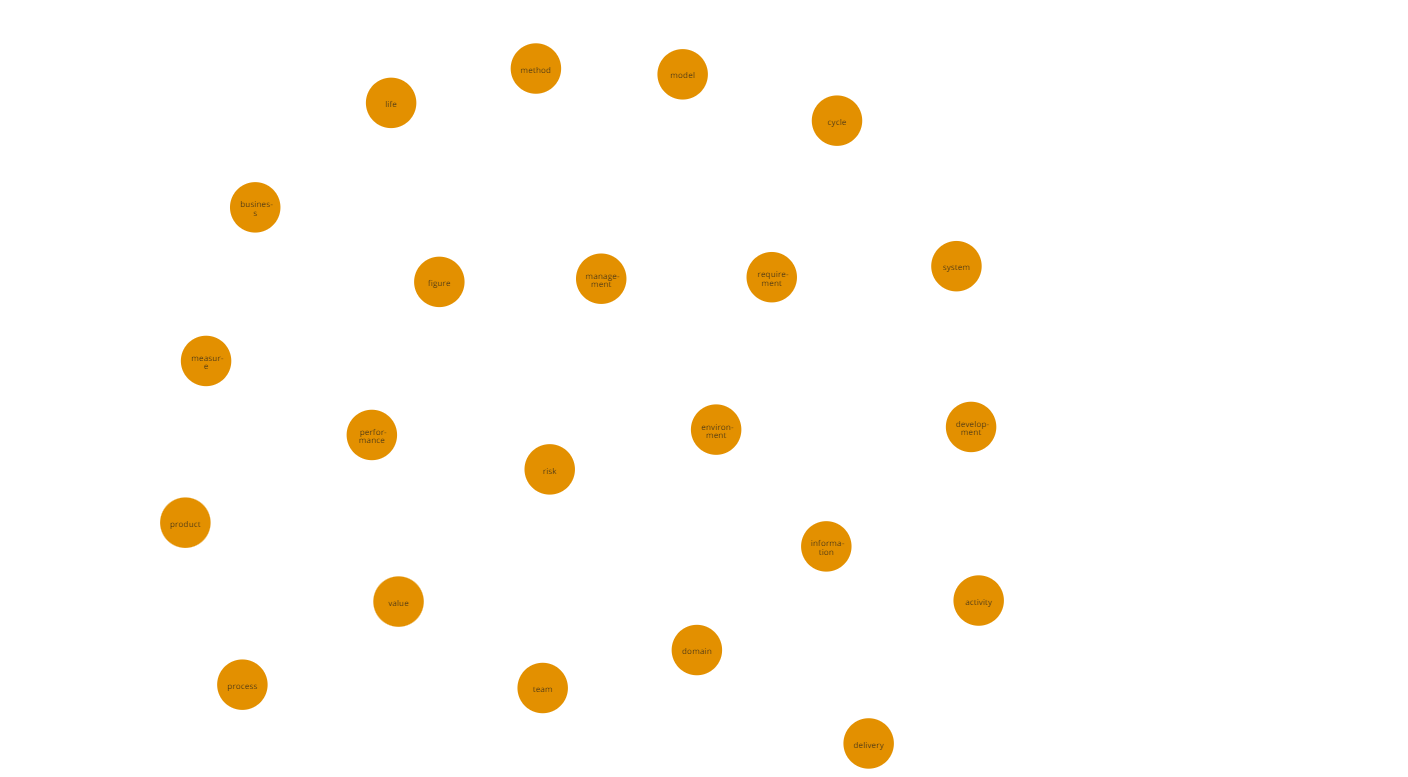

###Feature Nodes: Synonyms & Definitions

In [ ]:
from neo4j import GraphDatabase
import pandas as pd

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# Load the CSV file containing the term definitions and synonyms
file_path = '/content/project_management_definitions_and_synonyms.csv'
df = pd.read_csv(file_path)

# Function to update Term nodes with definitions and synonyms
def update_term_features(tx, term, definition, synonym):
    # Update the Term node with definition and synonym properties
    query = """
    MATCH (c:Term {name: $term})
    SET c.definition = $definition
    SET c.synonyms = coalesce(c.synonyms, []) + [$synonym]
    """
    tx.run(query, term=term, definition=definition, synonym=synonym)

# Function to process the CSV and update Term nodes in Neo4j
def process_feature_relationships(df):
    with driver.session() as session:
        for index, row in df.iterrows():
            term = row['Term']  # Adjusted to match your CSV column name
            definition = row['Definition']
            synonyms = row['Synonyms'].split(", ")  # Assuming synonyms are separated by commas

            # Update the Term node with definition and each synonym
            for synonym in synonyms:
                session.execute_write(update_term_features, term, definition, synonym)

# Step 1: Process the CSV and update Term nodes with synonyms and definitions in Neo4j
process_feature_relationships(df)

# Close the Neo4j connection
driver.close()

print("Synonym and definition features have been added to Term nodes in Neo4j!")


Synonym and definition features have been added to Term nodes in Neo4j!


Here we can see that for the term "Value" we have it's feature nodes synonyms and definition:

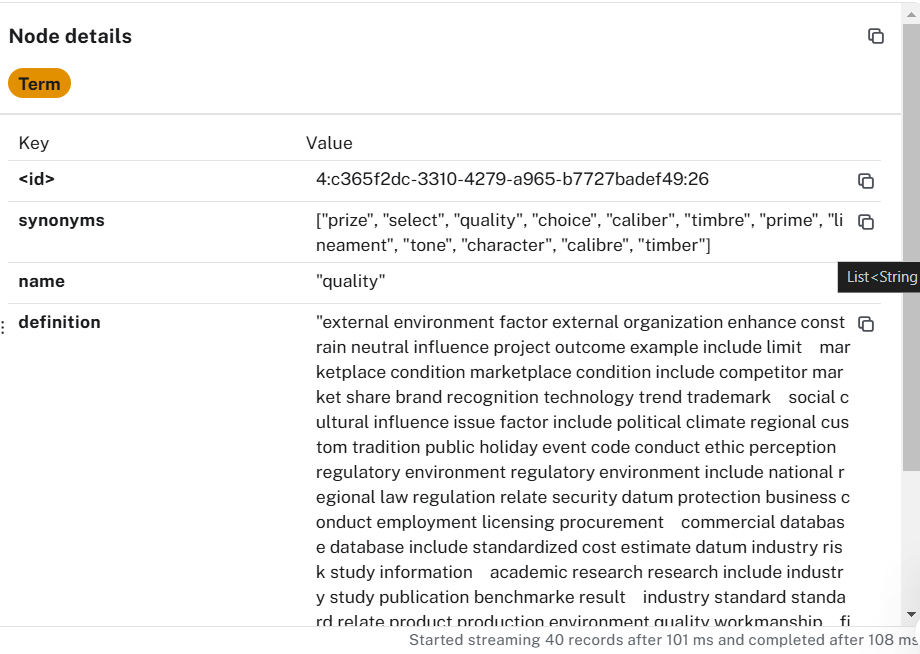

###Feature Nodes : Adding Figures

In [ ]:
!pip install pandas

In [ ]:
import numpy as np

In [ ]:
import pandas as pd


In [ ]:
# Load the Excel file
file_path_figure = '/content/drive/MyDrive/Colab_Data/figures_descriptions_final.xlsx'
df = pd.read_excel(file_path_figure)

# Display the first few rows of the Excel file
df

,Figure/Table Title,Description
0,Figure 2-1. Example of a System for Value Deli...,Figure 2-1 is an example of a system for value...
1,Figure 2-2. Components of a Sample System for ...,Figure 2-2 shows the components of a sample sy...
2,Figure 2-3. Example of Information Flow,Figure 2-3 represents a model of the flow of i...
3,Figure 2-4. Sample Product Life Cycle,Figure 2-4 represents a Sample Product Life Cy...
4,Figure 3-1. Overlap of Project Management and ...,The overlap between Project Management and Gen...
...,...,...
78,Table X4-1. Views of Project and Product Manag...,Table X4-1 shows the views of project and prod...
79,Figure X4-1. Global Business Trends Influencin...,Figure X4-1 illustrates three global trends th...
80,Figure X4-2. The Changing Relationship Between...,The Changing Relationship Between an Organizat...
81,Figure X4-3. Supporting Strategies for Continu...,Establishing stable teams is a key supporting ...


In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import spacy

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# Load the concept terms and figure descriptions
concept_terms_path = '/content/refined_key_terms.csv'
figure_descriptions_path = '/content/drive/MyDrive/Colab_Data/figures_descriptions_final.xlsx'
# Load the concept terms CSV file
terms_df = pd.read_csv(concept_terms_path)
concept_terms = terms_df['Term'].tolist()

# Load the figure descriptions Excel file
figures_df = pd.read_excel(figure_descriptions_path)

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to add figures/tables with separate properties for title and description
def add_figure_with_description(tx, term, figure_title, description):
    query = """
    MATCH (t:Term {name: $term})
    SET t.figure_titles = COALESCE(t.figure_titles, []) + [$figure_title],
        t.figure_descriptions = COALESCE(t.figure_descriptions, []) + [$description]
    """
    tx.run(query, term=term, figure_title=figure_title, description=description)

# Function to process the figures and add them as properties to Term nodes
def process_figures_and_relationships(figures_df, concept_terms):
    with driver.session() as session:
        figures_added = 0

        for index, row in figures_df.iterrows():
            figure_title = row['Figure/Table Title']
            description = row['Description']

            # Ensure the description is a valid string
            if not isinstance(description, str):
                continue

            # Step 1: Link figure to relevant concepts
            description_doc = nlp(description)
            linked = False
            for term in concept_terms:
                if term.lower() in description_doc.text.lower():
                    session.execute_write(add_figure_with_description, term, figure_title, description)
                    figures_added += 1
                    linked = True

            if not linked:
                print(f"Figure '{figure_title}' has no matching term.")

        print(f"Total figures added: {figures_added}")

# Execute the function to add figure information to the Term nodes
process_figures_and_relationships(figures_df, concept_terms)

# Close the Neo4j connection
driver.close()

print("Figures and descriptions have been added as properties to the main Term nodes in Neo4j!")


Total figures added: 375
Figures and descriptions have been added as properties to the main Term nodes in Neo4j!


##Edges: Relationships Development

###1. Parent-Child : Hiearchical Relationship
where the Parent=Main Concepts & the Child=Term Extracted




In [ ]:
# Initialize the Neo4j driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Read the CSV file containing the final concept mapping
file_path = '/content/final_concept_mapping_refined.csv'
df = pd.read_csv(file_path)

# Function to create nodes for main concepts
def create_main_concept_node(tx, concept):
    tx.run("MERGE (c:MainConcept {name: $concept})", concept=concept)

# Function to create an edge (hierarchical relationship) between a term and its main concept
def create_hierarchical_relationship(tx, term, concept):
    tx.run("""
        MATCH (t:Term {name: $term})
        MERGE (c:MainConcept {name: $concept})
        MERGE (t)-[:BELONGS_TO]->(c)
    """, term=term, concept=concept)

# Function to create nodes and hierarchical relationships from the CSV data
def build_hierarchical_relationships(df):
    with driver.session() as session:
        for index, row in df.iterrows():
            term = row['Term']
            concept = row['Concept']

            # Create the main concept node
            session.execute_write(create_main_concept_node, concept)

            # Create the hierarchical relationship (Term -> Main Concept)
            session.execute_write(create_hierarchical_relationship, term, concept)

# Execute the function to build relationships
build_hierarchical_relationships(df)

# Close the Neo4j connection
driver.close()

print("Hierarchical relationships between terms and main concepts have been created!")


Hierarchical relationships between terms and main concepts have been created!


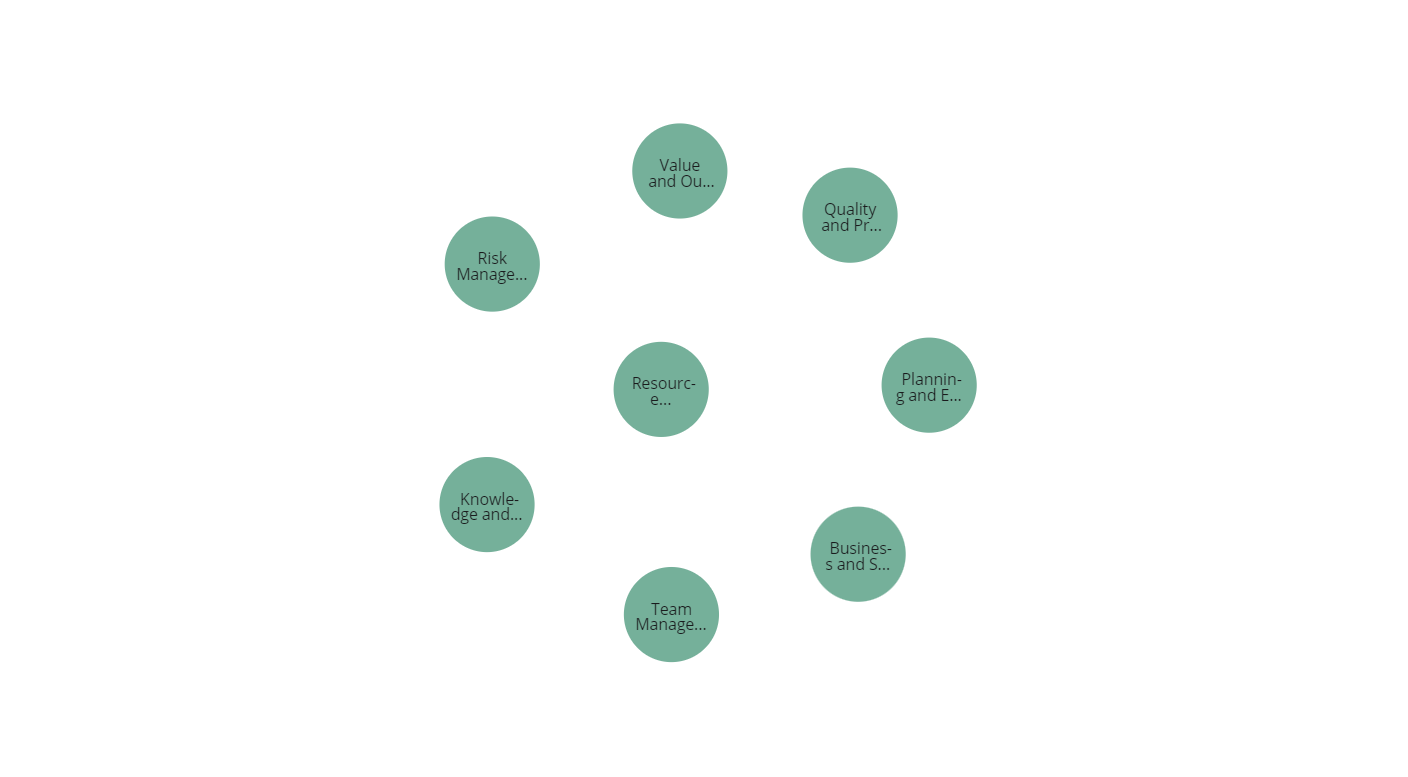

This is the graph of the hiearchial relationships (parent-child):
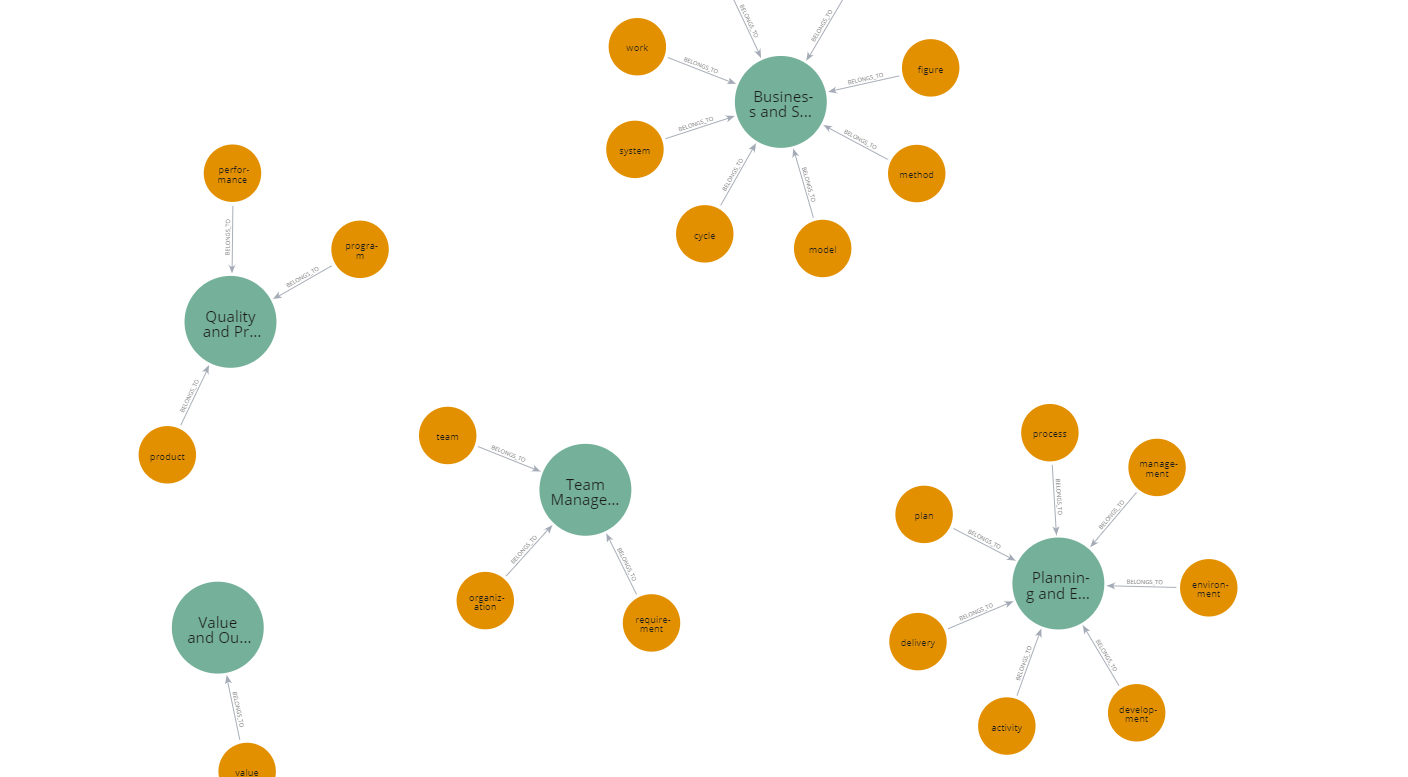

### 2. Parent-Parent Relationship

In [ ]:
driver = GraphDatabase.driver(uri, auth=(username, password))

# List of main concepts
main_concepts = [
    "Team Management",
    "Business and System",
    "Planning and Execution",
    "Quality and Program Management",
    "Value and Outcome",
    "Risk Management",
    "Resource Management",
    "Knowledge and Information"
]


# Relationships between main concepts with a more hierarchical structure
concept_relationships = [
    ("Business and System", "Team Management", "parent_of"),
    ("Business and System", "Quality and Program Management", "enables"),
    ("Planning and Execution", "Risk Management", "depends_on"),
    ("Planning and Execution", "Resource Management", "supports"),
    ("Planning and Execution", "Team Management", "coordinates"),
    ("Risk Management", "Planning and Execution", "mitigates"),
    ("Knowledge and Information", "Resource Management", "informs"),
    ("Value and Outcome", "Quality and Program Management", "enhances"),
    ("Business and System", "Planning and Execution", "guides"),
    ("Resource Management", "Knowledge and Information", "provides"),
    ("Team Management", "Planning and Execution", "coordinates")
]

# Function to create nodes for main concepts
def create_main_concept_node(tx, concept):
    query = "MERGE (c:MainConcept {name: $concept})"
    tx.run(query, concept=concept)

# Function to create relationships between main concepts
def create_concept_relationship(tx, concept1, concept2, relationship):
    query = """
    MATCH (c1:MainConcept {name: $concept1}), (c2:MainConcept {name: $concept2})
    MERGE (c1)-[:{rel}]->(c2)
    """
    query = query.replace("{rel}", relationship)  # Replace relationship dynamically
    tx.run(query, concept1=concept1, concept2=concept2)

# Function to build the nodes and relationships
def build_concept_relationships():
    with driver.session() as session:
        # Step 1: Create main concept nodes
        for concept in main_concepts:
            session.execute_write(create_main_concept_node, concept)

        # Step 2: Create relationships between main concepts
        for concept1, concept2, relationship in concept_relationships:
            session.execute_write(create_concept_relationship, concept1, concept2, relationship)

# Execute the function to build relationships
build_concept_relationships()

# Close the Neo4j connection
driver.close()

print("Main concepts and relationships have been added to the Neo4j database!")

Main concepts and relationships have been added to the Neo4j database!


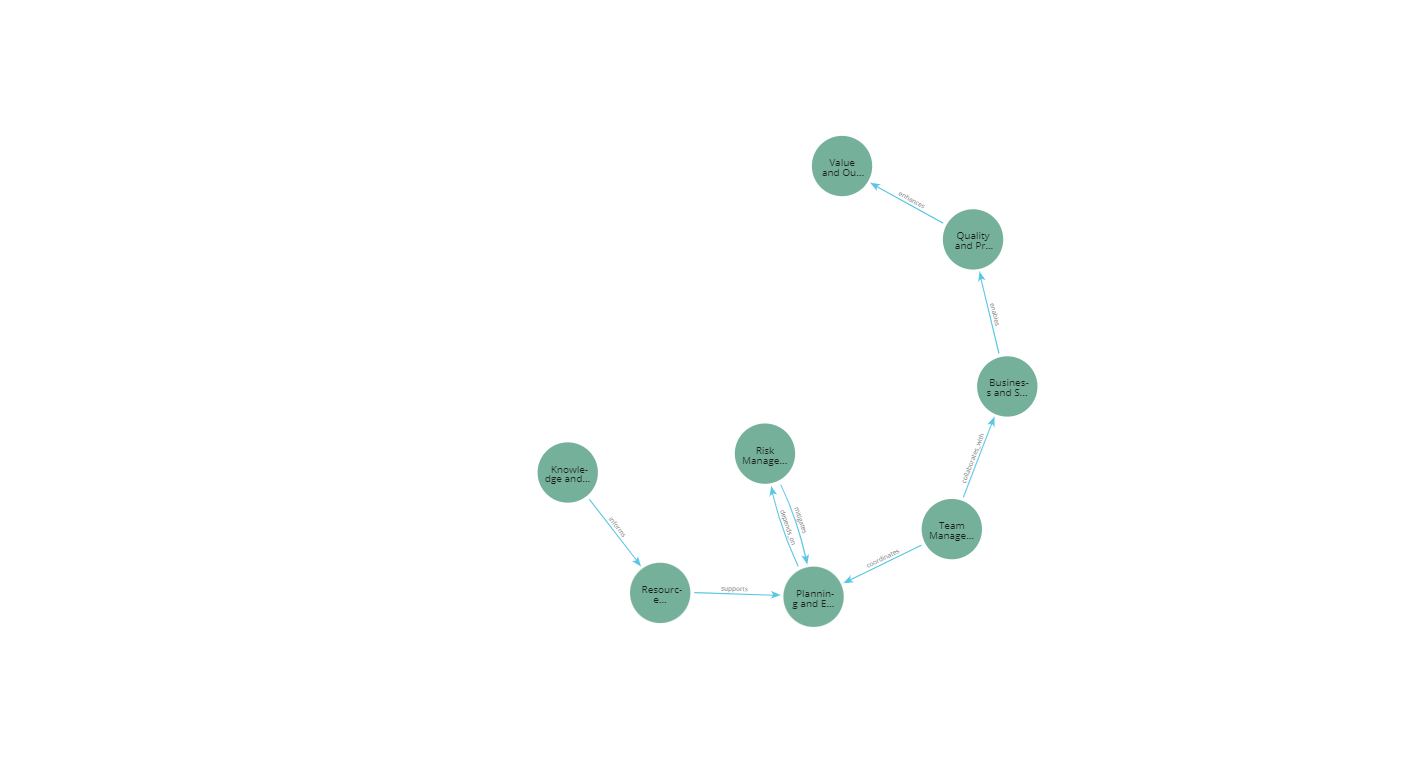

###3. Child-child : Taxonomic and Non-Taxonomic Relationships



> The taxonomic relationships reflect broader to narrower connections (e.g., from Main Category → Subcategory → Term). This can still be modeled as SVO, but the relationships will focus on "is part of", "is a type of", or "belongs to" type connections.

> We also need richer relationships which are non-taxonomic such as "depends on", "leads to", "enables", "contributes to", "is affected by", etc. These connections might span across categories and involve more detailed, context-dependent relationships.


In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/extracted_data_cleaned.csv'
df = pd.read_csv(file_path)

# Extract the 'Cleaned Page Text' column and concatenate all entries into a single string
cleaned_text = " ".join(df['Cleaned Page Text'].dropna().astype(str))

# Save the cleaned text into a text file
output_file_path = '/content/cleaned_page_text.txt'
with open(output_file_path, 'w') as text_file:
    text_file.write(cleaned_text)

# Confirm the text file creation
output_file_path


'/content/cleaned_page_text.txt'

In [ ]:
from neo4j import GraphDatabase
import spacy
import pandas as pd
from collections import Counter

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Load the extracted key terms from the CSV
key_terms_df = pd.read_csv('/content/refined_key_terms.csv')
key_terms = key_terms_df['Term'].tolist()  # List of terms to filter SVOs

# Load the cleaned text file
with open('/content/cleaned_page_text.txt', 'r') as file:
    cleaned_text = file.read()

# Function to extract SVO relationships using spaCy
def extract_svo_relationships(text, key_terms):
    doc = nlp(text)
    svo_relationships = []

    for sent in doc.sents:
        for token in sent:
            if token.dep_ == 'nsubj':  # subject
                subject = token.text
                verb = token.head.text  # verb (head of the subject)
                for child in token.head.children:
                    if child.dep_ == 'dobj':  # direct object
                        obj = child.text
                        # Only append if both subject and object are in the key terms list
                        if subject in key_terms and obj in key_terms:
                            svo_relationships.append((subject, verb, obj))

    return svo_relationships

# Function to create nodes and SVO relationships in Neo4j
def create_svo_relationship(tx, subject, verb, obj):
    query = f"""
    MERGE (s:Term {{name: $subject}})
    MERGE (o:Term {{name: $obj}})
    MERGE (s)-[:`{verb}`]->(o)
    """
    tx.run(query, subject=subject, obj=obj)

# Function to store relationships in Neo4j
def process_svo_relationships(svo_relationships):
    with driver.session() as session:
        for svo in svo_relationships:
            subject, verb, obj = svo
            session.execute_write(create_svo_relationship, subject, verb, obj)

# Step 1: Extract SVO relationships from the cleaned text
relationships = extract_svo_relationships(cleaned_text, key_terms)

# Step 2: Count the frequency of each SVO relationship
relationship_counts = Counter(relationships)

# Step 3: Define a threshold and filter the relationships
threshold = 1  # You can adjust this value to control the number of relationships
filtered_relationships = [rel for rel, count in relationship_counts.items() if count >= threshold]

# Step 4: Process and store the filtered SVO relationships in Neo4j
process_svo_relationships(filtered_relationships)

# Close the Neo4j connection
driver.close()

print(f"SVO relationships with a threshold of {threshold} have been created in Neo4j!")


SVO relationships with a threshold of 1 have been created in Neo4j!


In [ ]:
print(filtered_relationships)

[('activity', 'manage', 'benefit'), ('organization', 'create', 'value'), ('system', 'provide', 'system'), ('member', 'represent', 'organization'), ('figure', 'provide', 'figure'), ('impact', 'objective', 'organization'), ('figure', 'create', 'environment'), ('team', 'continue', 'work'), ('environment', 'bring', 'team'), ('work', 'outcome', 'work'), ('organization', 'choose', 'value'), ('environment', 'prioritize', 'leadership'), ('team', 'deliver', 'leadership'), ('team', 'maintain', 'environment'), ('environment', 'contribute', 'process'), ('team', 'choose', 'process'), ('delivery', 'improve', 'decision'), ('method', 'reduce', 'figure'), ('team', 'modify', 'impact'), ('work', 'identify', 'team'), ('system', 'thinking', 'system'), ('system', 'monitor', 'leadership'), ('activity', 'overview', 'process'), ('domain', 'represent', 'process'), ('domain', 'achieve', 'cycle'), ('domain', 'operate', 'organization'), ('activity', 'undertake', 'domain'), ('information', 'misinterpret', 'analysis

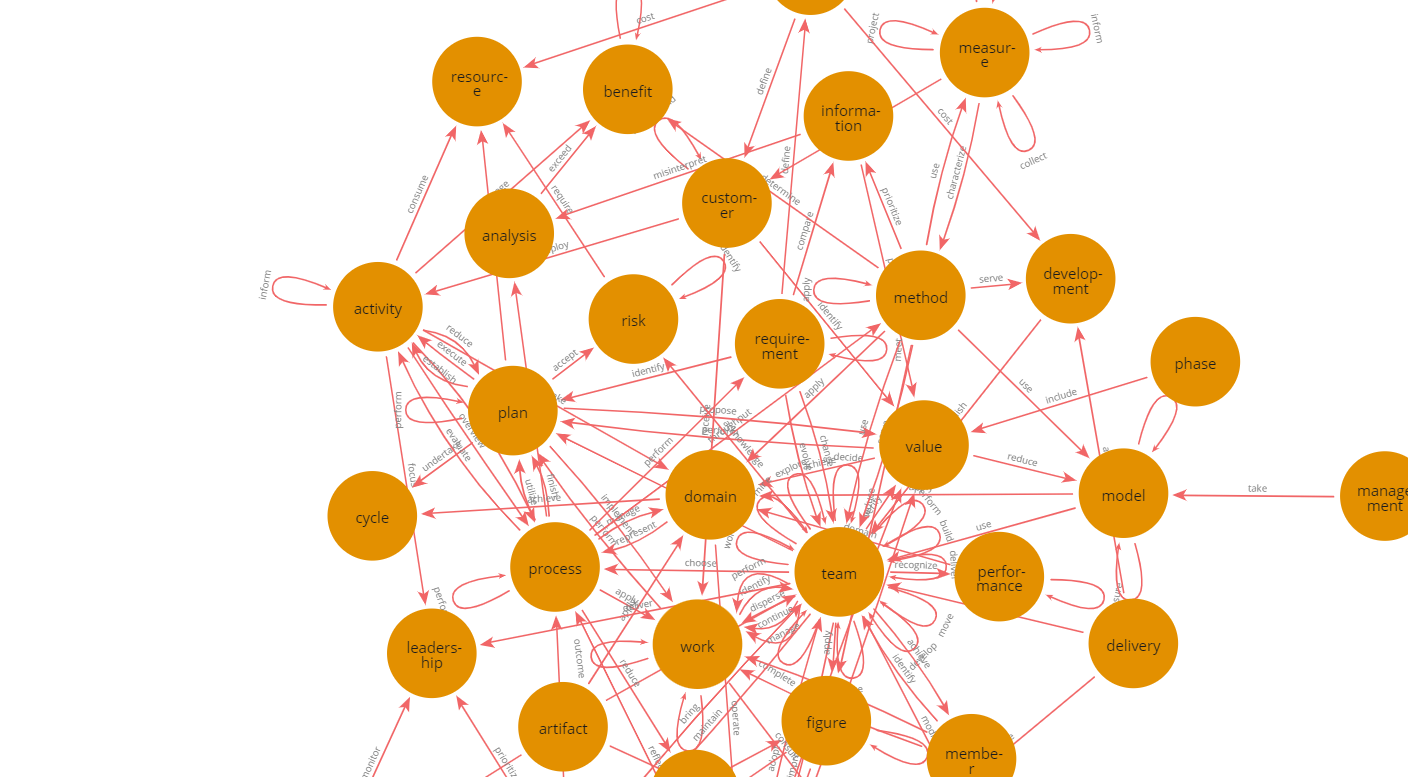

Now we have a combination of all of the relationships:

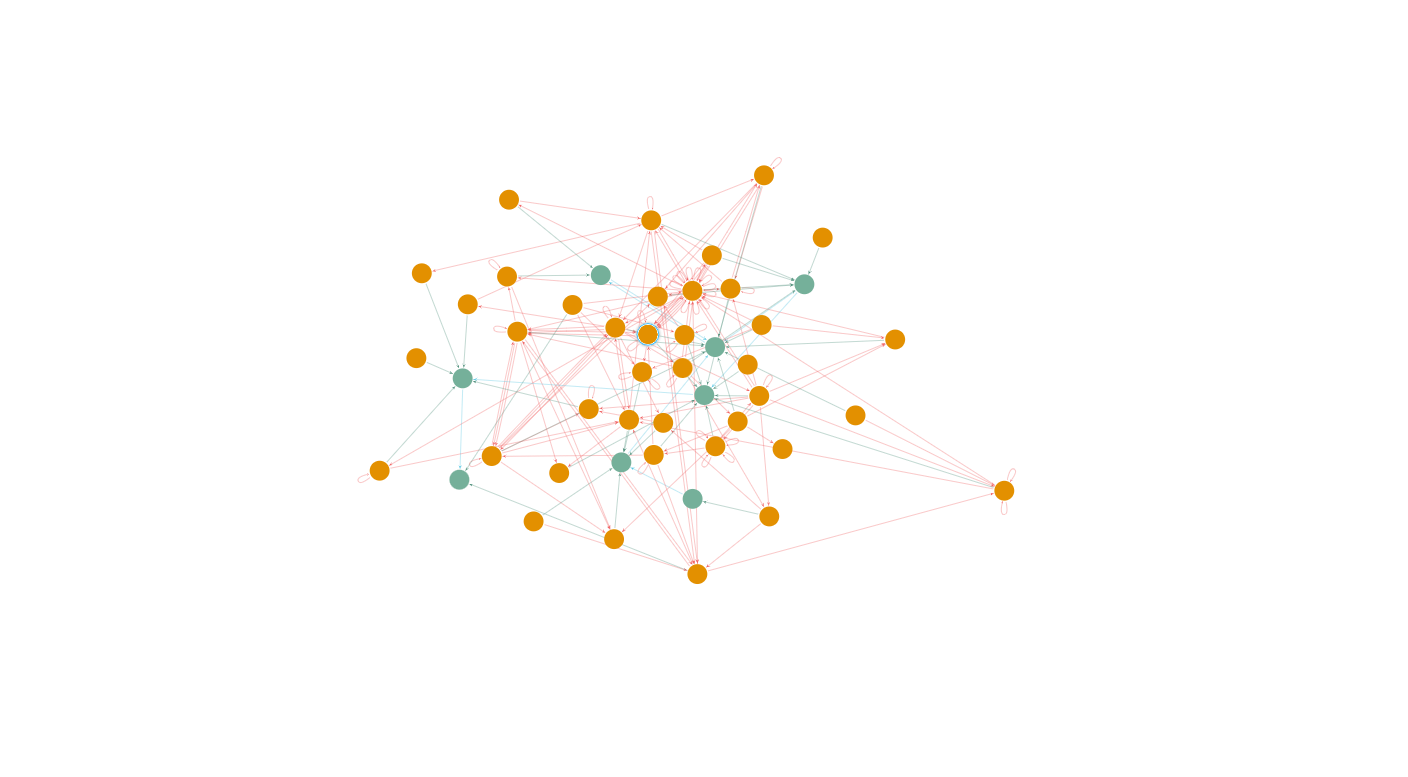



###4. Feature Edges

In [ ]:
from neo4j import GraphDatabase

# Connect to Neo4j
driver = GraphDatabase.driver(uri, auth=(username, password))

# List of dependency features to add to relationships
# (concept_1, concept_2, relationship_type, dependency_feature)
dependency_features = [
    ("Team Management", "Business and System", "collaborates_with", "start-to-finish"),
    ("Planning and Execution", "Risk Management", "depends_on", "finish-to-start"),
    ("Quality and Program Management", "Value and Outcome", "enhances", "start-to-start"),
    ("Resource Management", "Planning and Execution", "supports", "finish-to-start"),
    ("Knowledge and Information", "Resource Management", "informs", "start-to-finish"),
    ("Risk Management", "Planning and Execution", "mitigates", "start-to-start"),
    ("Business and System", "Quality and Program Management", "enables", "finish-to-start"),
    ("Team Management", "Planning and Execution", "coordinates", "finish-to-finish"),
]

# Function to add feature attributes to relationships
def add_dependency_features():
    with driver.session() as session:
        for concept1, concept2, relationship_type, dependency_feature in dependency_features:
            session.execute_write(add_feature_to_relationship, concept1, concept2, relationship_type, dependency_feature)

# Function to add a feature to an existing relationship
def add_feature_to_relationship(tx, concept1, concept2, relationship_type, dependency_feature):
    query = """
    MATCH (n1:MainConcept {name: $concept1})-[r:`{rel}`]->(n2:MainConcept {name: $concept2})
    SET r.dependency_type = $dependency_feature
    """
    query = query.replace("{rel}", relationship_type)  # Dynamically insert the relationship type
    tx.run(query, concept1=concept1, concept2=concept2, dependency_feature=dependency_feature)

# Run the function to add feature attributes to existing relationships
add_dependency_features()

# Close the Neo4j connection
driver.close()

print("Dependency features added to relationships in Neo4j!")


Dependency features added to relationships in Neo4j!


Here we added dependencies that are features assigned to the edges between nodes in our Neo4j graph. Specifically, we used dependency types such as:
1. *Start-to-Finish Dependency*
  * Explanation: This means that the dependent concept (e.g., Task B) cannot finish until the preceding concept (e.g., Task A) has started.
  * Example: Think of it as a situation where the documentation phase cannot be finalized until the quality control review has started, because the review might lead to necessary changes to the documentation.
2. *Finish-to-Start Dependency*
  * Explanation: This is one of the most common dependency types. It means that a concept (e.g., Task B) cannot start until a preceding concept (e.g., Task A) has finished.
  * Example: In a project management scenario, design phase cannot start until all requirements gathering has been completed.
3.*Start-to-Start Dependency*
  * Explanation: This means that the dependent concept (e.g., Task B) cannot start until the preceding concept (e.g., Task A) has started. Both concepts can proceed simultaneously once started.
  * Example: For example, in project planning, the prototyping phase can only start once the design phase has begun, as the prototype must be developed based on initial design inputs.
4. *Finish-to-Finish Dependency*
  * Explanation: This means that the dependent concept (e.g., Task B) cannot finish until the preceding concept (e.g., Task A) has finished.
  * Example: For instance, the final testing phase cannot finish until the development phase has finished, as developers may need to address issues during testing.

**How Dependencies Are Useful in Our Project:**

When a user interacts with our educational platform, these dependencies help them understand the logical order or relationships between various phases or steps. Let’s take an example in the context of risk management:

- If a customer searches for information on Risk Management, the system should let them know that Monitoring must happen first (e.g., a finish-to-start dependency).
- This means that Monitoring is a prerequisite, and only after it’s completed can effective Risk Management be conducted.

**Types of Dependencies Added Between Concepts in our Graph:**
- *Between Main Concepts (Parent-Parent relationships)*:

  - Team Management depends on Planning and Execution ("finish-to-start").
Resource Management supports Planning and Execution ("finish-to-start").
  - Quality and Program Management enhances Value and Outcome ("start-to-start").

- *Between Terms (Child-Child relationships)*:

  These dependencies can exist between specific terms (e.g., "Risk" and "Monitoring") where "Risk" cannot be managed until "Monitoring" is complete.
  These relationships allow users to understand specific steps that are crucial before moving to the next phase.

Here is for example the output of a query showing the nodes that have NonNull dependency_type relationship:

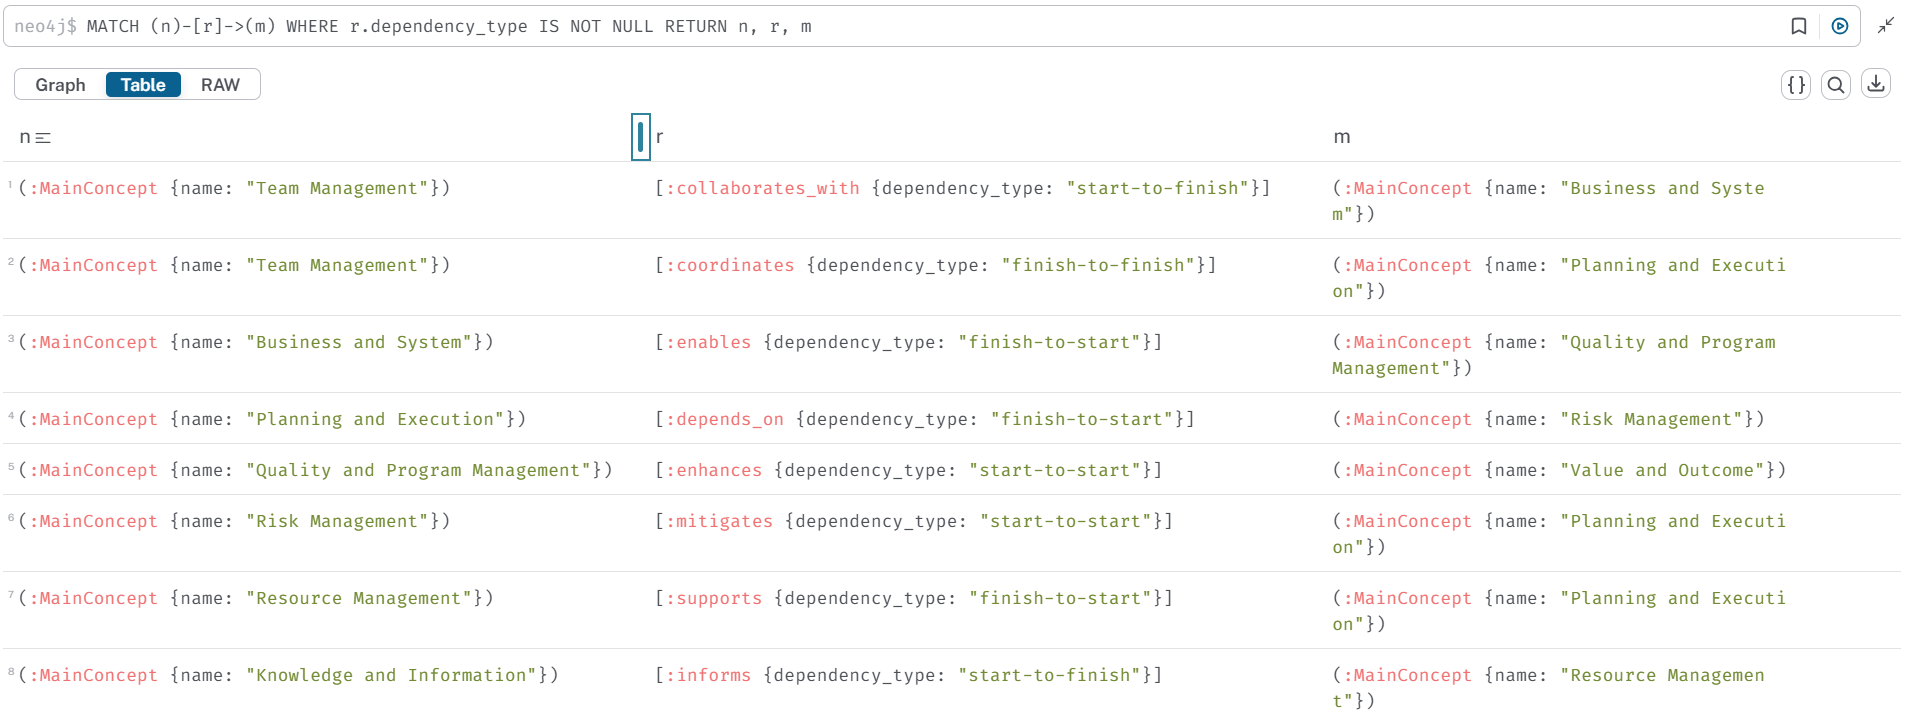

##**NB: Graph Evaluation:**

We have already built the knowledge graph by extracting key relationships and linking different entities like *Terms*, *Main Concepts*, *Figures*, *Synonyms*, and *Definitions*. Let's briefly discuss how we evaluated this graph:

1. **Data Quality Metrics:** We performed checks to ensure that all nodes and relationships were created without duplication or inconsistency. This includes validating node counts (e.g., Term, Figure nodes) and ensuring there are no orphan nodes (nodes that are not connected to others).
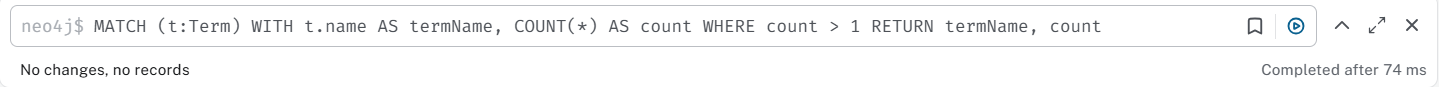
2. **Graph Structure:** We analyzed the degree distribution of nodes, checked the number of isolated nodes, and verified the centrality of important nodes (MainConcept, Term). This was done to ensure that the graph structure supports efficient propagation of information.
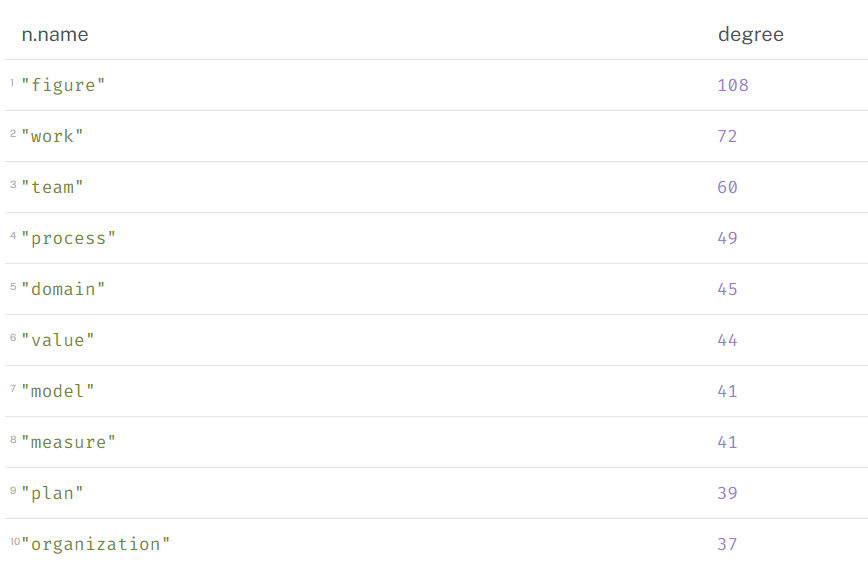

Here is the final database:

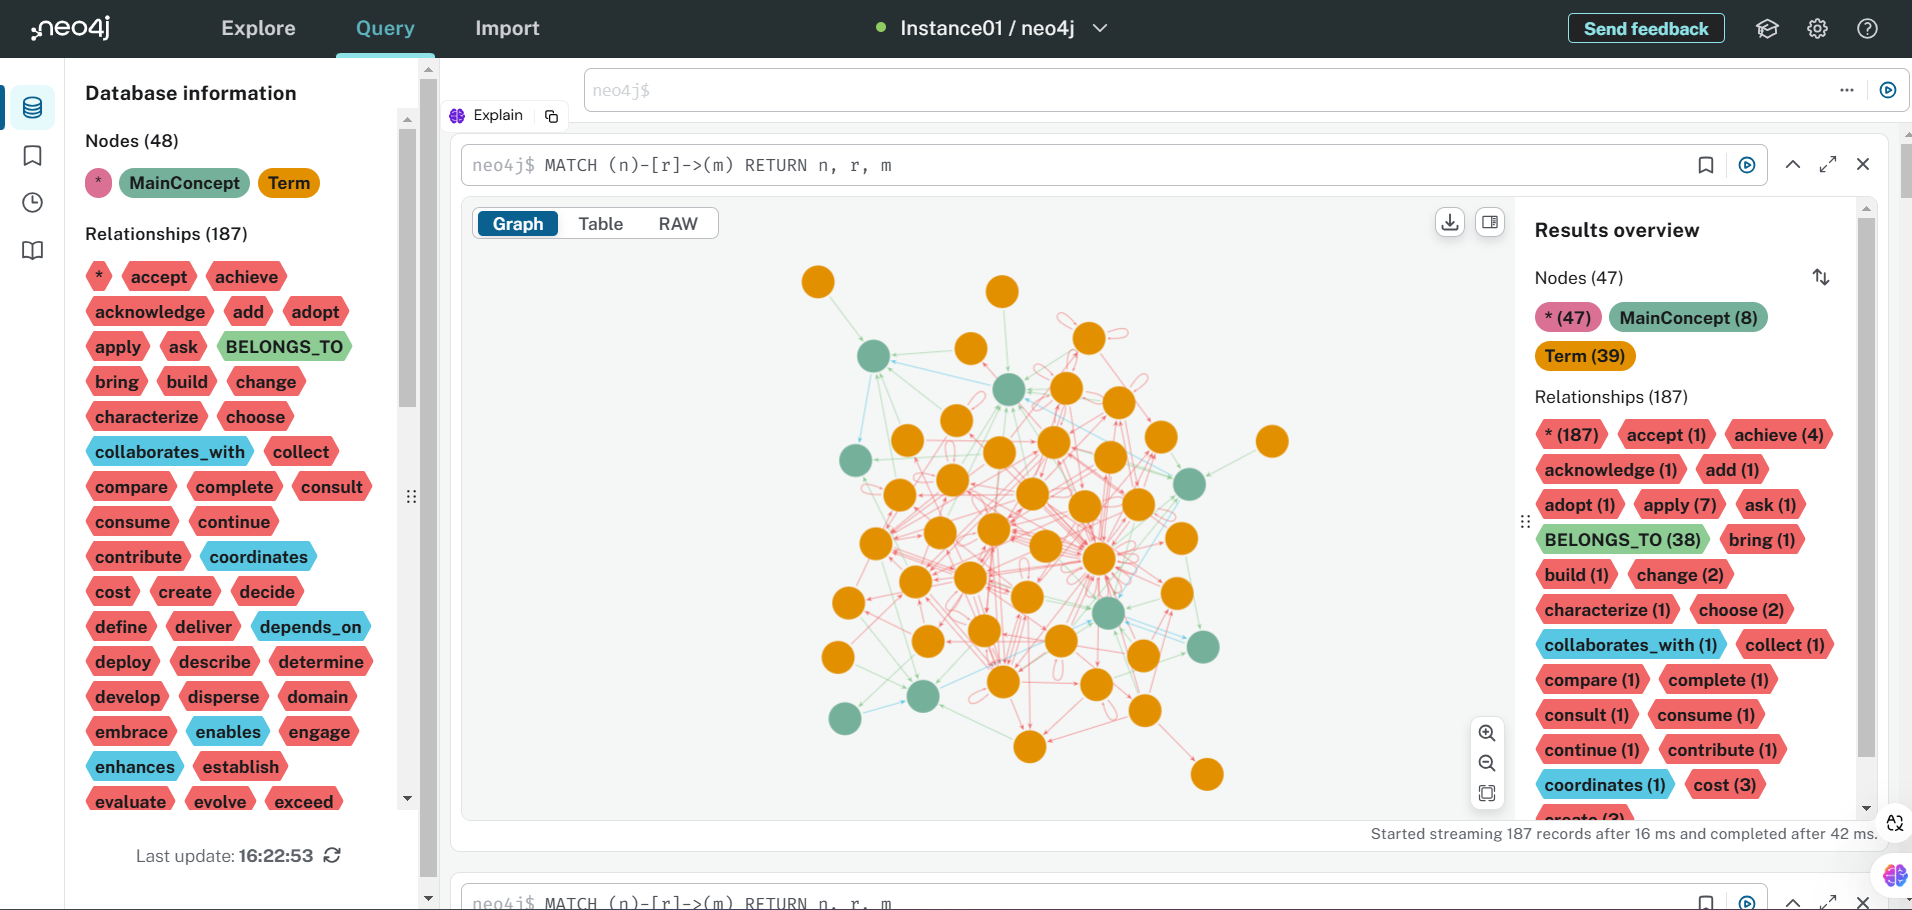

##Neo4J Needed Queries


To visualize only hierarchical relationships (BELONGS_TO):

```
 MATCH (n)-[r:BELONGS_TO]->(m)
 RETURN n, r, m
```
To visualize only the relationships that are based on verbs from SVO extraction:
```
MATCH (n)-[r]->(m)
WHERE type(r) <> 'BELONGS_TO'
RETURN n, r, m
```
To visualize entire graph:
```
MATCH (n)-[r]->(m)
RETURN n, r, m

```
Delete All Relationships Only (if you want to keep nodes):
```
MATCH ()-[r]-()
DELETE r
```
Delete Specific Relationships (e.g., HAS_SYNONYM, HAS_DEFINITION):
```
MATCH ()-[r:HAS_SYNONYM|HAS_DEFINITION]->()
DELETE r
```
To delete all graph:
```
MATCH (n)
DETACH DELETE n
```

# Modeling

##Preparations

In [ ]:
!pip install langchain-community

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [ ]:
# !pip uninstall torch torchvision -y
#!pip install torch torchvision


In [ ]:
!pip install transformers sentence-transformers


In [ ]:
!pip install neo4j pandas networkx

In [ ]:
#!pip uninstall dgl # Uninstall any existing DGL installations to avoid conflicts.
!pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html # Install DGL with the wheel for PyTorch 2.4.

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Usin

In [ ]:
!pip install --upgrade torchvision

  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.21.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.4.127-py3-none-

In [ ]:
!pip install torch
!pip install torch-geometric
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv


In [ ]:
!pip install transformers faiss-cpu torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 61.9 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision

In [ ]:
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
from torch_geometric.utils import from_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from pydantic import BaseModel
import json
from transformers import BertTokenizer, BertModel, pipeline


In [ ]:
# Connect to your Neo4j instance
uri = "neo4j+s://30e67dcf.databases.neo4j.io"
username = "neo4j"  # Your Neo4j username
password = "No4yf_DI3pb2PfMLZUeUHRU4mIW2AA4UKEd9ySKR9HM"  # Your Neo4j password

In [ ]:
from neo4j import GraphDatabase

# Initialize Neo4j driver
driver = GraphDatabase.driver(uri, auth=(username, password))

# Fetch nodes and relationships from Neo4j with all properties and edges
def fetch_graph_data(batch_size=1000):
    nodes_data = {}
    edges_data = []

    with driver.session() as session:
        # Fetch all nodes in batches to prevent memory issues
        nodes_query = "MATCH (n) RETURN n SKIP $skip LIMIT $limit"
        skip = 0
        while True:
            result = session.run(nodes_query, skip=skip, limit=batch_size)
            batch_nodes = False
            for record in result:
                batch_nodes = True
                node = record["n"]
                node_id = node.element_id  # Unique node identifier
                properties = node._properties  # Get all properties of the node
                nodes_data[node_id] = properties
            if not batch_nodes:
                break
            skip += batch_size

        # Fetch all edges in batches to prevent memory issues
        edges_query = "MATCH (n)-[r]->(m) RETURN n, r, m SKIP $skip LIMIT $limit"
        skip = 0
        while True:
            result = session.run(edges_query, skip=skip, limit=batch_size)
            batch_edges = False
            for record in result:
                batch_edges = True
                source_node = record["n"]
                target_node = record["m"]
                edge = (source_node.element_id, target_node.element_id)
                edges_data.append(edge)
            if not batch_edges:
                break
            skip += batch_size

    return nodes_data, edges_data

# Fetch the graph data
nodes_data, edges_data = fetch_graph_data()


In [ ]:
# Example of how to inspect the data
print("Nodes Data:", nodes_data)
print("Edges Data:", edges_data)

Nodes Data: {'4:fe3ca456-e4fa-4fd1-8fe3-ff0fb119fac2:0': {'figure_titles': ['Figure 3-5. Focus on Value', 'Figure 3-10. Navigate Complexity', 'Figure 3-12. Embrace Adaptability and Resiliency', 'Figure 2-2. Examples of Project Stakeholders', 'Figure 2-4. Team Performance Domain', 'Table 2-3. Checking Outcomes—Team Performance Domain', 'Figure 2-11. Life Cycle with Adaptive Development Approach', 'Figure 2-25. Mood Board', 'Figure 2-30. Burnup Chart', 'Figure 2-31. Planned and Actual Spend Rates', 'Figure 3-2. Selecting the Initial Development Approach', 'Table 3-1. Common Situations and Tailoring Suggestions', 'Table 4-1. Mapping of Models Likely to Be Used in Each Performance Domain', 'Table 4-2. Mapping of Methods Likely to Be Used in Each Performance Domain (cont.)', 'Table X4-1. Views of Project and Product Management', 'Figure X4-3. Supporting Strategies for Continuous Value Delivery', 'Table X4-2. Unique Characteristics of Projects, Programs, and Products'], 'synonyms': ['team up

In [ ]:
import torch
from torch_geometric.data import Data

# Updated function to convert fetched Neo4j data to PyTorch Geometric format
def convert_to_pyg_data(nodes_data, edges_data):
    # Create node indexing based on node IDs
    node_index = {node_id: i for i, node_id in enumerate(nodes_data.keys())}

    # Convert edges to tensor (directed)
    edge_index = torch.tensor(
        [[node_index[src], node_index[tgt]] for src, tgt in edges_data],
        dtype=torch.long
    ).t().contiguous()

    # Create node feature matrix
    # For simplicity, we use one-hot encoding based on the number of nodes
    # Alternatively, we could use an embedding or a more sophisticated feature representation
    feature_dim = len(nodes_data)  # Each node will have a feature vector (one-hot encoding)
    x = torch.eye(len(nodes_data), dtype=torch.float)  # One-hot encoding for each node

    # Convert to PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index)

    return data

In [ ]:
# Convert to PyTorch Geometric format
pyg_data = convert_to_pyg_data(nodes_data, edges_data)

# Print out the results for inspection
print("Node Features (x):", pyg_data.x)
print("Edge Index (edge_index):", pyg_data.edge_index)
print("Number of Nodes:", pyg_data.num_nodes)

Node Features (x): tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
Edge Index (edge_index): tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  2,  2,  3,
          3,  3,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
          6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9,  9,
          9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13,
         13, 13, 13, 13, 13, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 17,
         17, 17, 17, 17, 17, 17, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20, 22, 22, 22, 22, 23, 24, 24, 24, 24, 24, 24, 24, 25,
         26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 2



> **Node Features (x):**
 This is a matrix with one-hot encoded features for each node. Each row corresponds to a node, and the column that contains a 1 represents the unique node ID. For example, if there are 48 nodes, each row is a vector of length 48 with a single 1 indicating the position of the node in the graph, and all other elements are 0.

> **Edge Index (edge_index):**This is a tensor that holds the indices of the nodes that are connected by edges. Each pair of values in the two rows of this tensor represents a directed edge from one node to another. The first row contains the source node indices, and the second row contains the target node indices. This means that node 0 is connected to node 40, node 0 is connected to node 1, and so on. Each edge is represented by a pair of node indices.

##Graph Embeddings Generation: Using GCN with DGI

In [ ]:
from torch_geometric.nn import GCNConv

In [ ]:
from torch_geometric.nn import DeepGraphInfomax, GCNConv # Import DGI as DeepGraphInfomax

In [ ]:
from torch_geometric.data import Data

In [ ]:
# Define the Graph Neural Network (GCN) encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Corruption function (shuffles node features)
def corruption(x, edge_index):
    return x[torch.randperm(x.size(0))], edge_index

# Initialize the DGI model
in_channels = pyg_data.num_node_features  # Number of input features (equal to the number of nodes since it's one-hot encoding)
out_channels = 64  # Dimension of output embeddings
encoder = GCNEncoder(in_channels, out_channels)

In [ ]:
model = DeepGraphInfomax(
    hidden_channels=out_channels,
    encoder=encoder,
    summary=lambda z, *args: torch.sigmoid(z.mean(dim=0)),  # Summary function
    corruption=corruption  # Corruption function
)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train():
    model.train()
    optimizer.zero_grad()
    pos_z, neg_z, summary = model(pyg_data.x, pyg_data.edge_index)
    loss = model.loss(pos_z, neg_z, summary)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train the model for some epochs
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

# Get the embeddings after training
model.eval()
with torch.no_grad():
    node_embeddings = model(pyg_data.x, pyg_data.edge_index)

print("Node Embeddings (after GCN):", node_embeddings)
# Close Neo4j connection
driver.close()

Epoch 0, Loss: 1.4001387357711792
Epoch 10, Loss: 1.208156943321228
Epoch 20, Loss: 0.9307700395584106
Epoch 30, Loss: 0.6329327821731567
Epoch 40, Loss: 0.39572134613990784
Epoch 50, Loss: 0.3215627074241638
Epoch 60, Loss: 0.7116270661354065
Epoch 70, Loss: 0.34489843249320984
Epoch 80, Loss: 0.28148216009140015
Epoch 90, Loss: 0.22280636429786682
Node Embeddings (after GCN): (tensor([[-0.1608, -0.2760, -0.0026,  ..., -0.0285, -0.0370, -0.0679],
        [-0.1316, -0.1685,  0.0317,  ..., -0.0463, -0.0395, -0.0827],
        [-0.0218, -0.1232, -0.0154,  ...,  0.0271,  0.1049,  0.1522],
        ...,
        [-0.0161, -0.0685,  0.0198,  ..., -0.0067, -0.0063,  0.0746],
        [ 0.0054, -0.1908, -0.0231,  ...,  0.0056, -0.0129,  0.0110],
        [ 0.0132, -0.0900,  0.0134,  ...,  0.0291,  0.0324,  0.0304]]), tensor([[ 0.0547,  0.0757, -0.1965,  ...,  0.1013,  0.0953,  0.2034],
        [-0.0243, -0.0456, -0.0773,  ...,  0.0422,  0.0350,  0.0451],
        [ 0.1849,  0.2618, -0.2842,  ...,  

***Understanding the Code Components:***


1. **Graph Neural Network (GCN) Encoder:**

- The *GCNEncoder* class defines a simple Graph Convolutional Network (GCN) with two convolutional layers.
- The *forward()* method applies a ReLU activation after the first convolution and then performs a second convolution.
- This encoder will capture node features and propagate information across graph edges, thus learning a good representation for each node.

2. **Corruption Function:**

- The corruption() function is used to create negative samples by shuffling the node features.

- This is part of the Deep Graph Infomax (DGI) approach, where you generate corrupted (negative) versions of the input to help the model learn meaningful features by contrasting positive and negative examples.

3. **Deep Graph Infomax (DGI) Model:**

- The DGI model (*DeepGraphInfomax*) is used for unsupervised learning of node representations.
- It learns embeddings by maximizing mutual information between the node representations and a summary representation of the graph.
- summary=lambda z, *args: torch.sigmoid(z.mean(dim=0)) defines the summary function, and corruption=corruption sets up the negative sampling strategy.

4. **Optimizer:**

- An Adam optimizer is used with a learning rate of 0.001 to update model parameters.

5. **Training Loop:**

- The training loop runs for 100 epochs.
- Every epoch, the positive (pos_z) and negative (neg_z) embeddings are generated, and a contrastive loss is computed to train the model.

6. **Obtaining Embeddings:**

- After training, the embeddings (z) are computed for downstream tasks.


In [ ]:
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    embeddings = model(pyg_data.x, pyg_data.edge_index)[0]  # Get node embeddings

# Convert PyTorch tensor to NumPy array
embeddings_np = embeddings.cpu().numpy()

# Evaluation Option 1: Clustering with K-Means
num_clusters = 5  # Adjust this based on your graph
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_np)

# Calculate clustering metrics (Silhouette Score)
silhouette_avg = silhouette_score(embeddings_np, cluster_labels)
print(f"Silhouette Score for K-Means clustering: {silhouette_avg:.4f}")

Silhouette Score for K-Means clustering: 0.1190


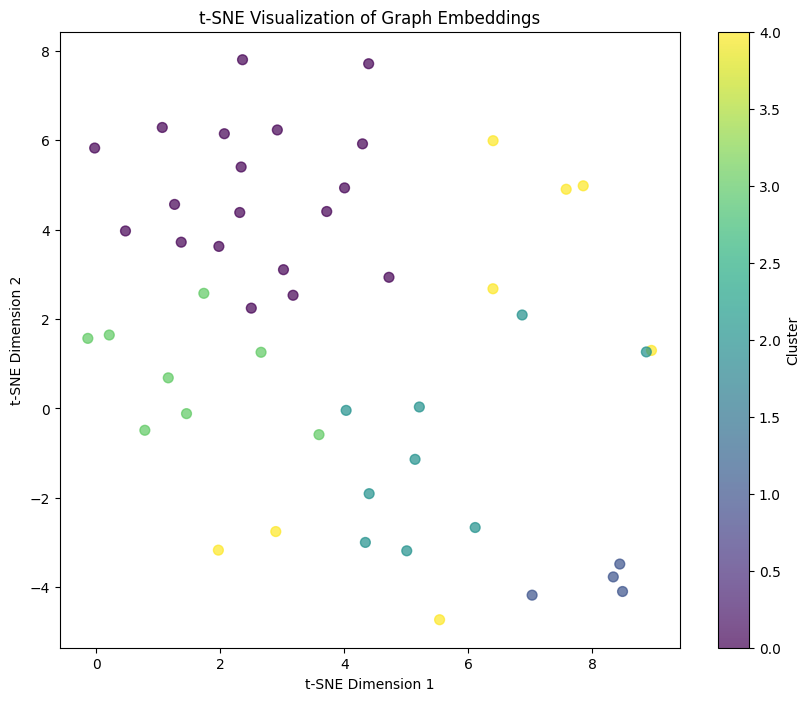

In [ ]:
# Evaluation Option 2: Visualization with t-SNE
tsne = TSNE(n_components=2, perplexity=15, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Plot the 2D t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label="Cluster")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Graph Embeddings")
plt.show()


In [ ]:

# Evaluation Option 3: Link Prediction (Optional)
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between node embeddings
cos_sim = cosine_similarity(embeddings_np)

# Placeholder for link prediction: Top k most similar nodes (this is just an example)
k = 5
for i in range(embeddings_np.shape[0]):
    # Get indices of the top k most similar nodes (excluding itself)
    similar_nodes = cos_sim[i].argsort()[-k-1:-1][::-1]
    print(f"Top {k} nodes most similar to node {i}: {similar_nodes}")

Top 5 nodes most similar to node 0: [14 10  9 22 15]
Top 5 nodes most similar to node 1: [27  9  7 22  0]
Top 5 nodes most similar to node 2: [19 42 46 47 18]
Top 5 nodes most similar to node 3: [15  9 10 22  6]
Top 5 nodes most similar to node 4: [ 6  5  9  7 13]
Top 5 nodes most similar to node 5: [ 7 22  6  9 15]
Top 5 nodes most similar to node 6: [15  9  7 22 10]
Top 5 nodes most similar to node 7: [ 6 13  1 22  5]
Top 5 nodes most similar to node 8: [22 32  7  1  6]
Top 5 nodes most similar to node 9: [15 22  6  1  0]
Top 5 nodes most similar to node 10: [ 0 22  6 15  9]
Top 5 nodes most similar to node 11: [35 14 42  0 43]
Top 5 nodes most similar to node 12: [ 7 17 29 28 34]
Top 5 nodes most similar to node 13: [ 7 32 28  6 22]
Top 5 nodes most similar to node 14: [ 0 42  9 15 22]
Top 5 nodes most similar to node 15: [22  9  6 10  0]
Top 5 nodes most similar to node 16: [39 44 30 35 10]
Top 5 nodes most similar to node 17: [29 12  7 34  5]
Top 5 nodes most similar to node 18: [

In [ ]:
import torch
import torch.nn.functional as F

def retrieve_relevant_nodes(query_embedding, node_embeddings, top_k=5):
    """
    Retrieve the top-k most relevant nodes based on the cosine similarity between query and node embeddings.

    Args:
    - query_embedding (torch.Tensor): The embedding for the query.
    - node_embeddings (torch.Tensor): The embeddings of the nodes.
    - top_k (int): The number of most relevant nodes to retrieve.

    Returns:
    - top_k_nodes (list): List of indices of the most relevant nodes.
    """
    # Normalize embeddings (cosine similarity requires normalized vectors)
    query_embedding = query_embedding / query_embedding.norm(p=2, dim=-1, keepdim=True)
    node_embeddings = node_embeddings / node_embeddings.norm(p=2, dim=-1, keepdim=True)

    # Compute cosine similarity
    cosine_sim = torch.matmul(query_embedding, node_embeddings.T)

    # Get top-k most similar nodes
    top_k_values, top_k_indices = torch.topk(cosine_sim, top_k)

    return top_k_indices

# Example query embedding (you can use a pretrained model to generate this for the query)
query_embedding = torch.randn(64)  # Random query embedding, replace it with the actual query embedding

# Retrieve top-k most relevant nodes
top_k_nodes = retrieve_relevant_nodes(query_embedding, node_embeddings[0])  # Use embeddings after GCN
print(f"Top K Relevant Nodes: {top_k_nodes}")


Top K Relevant Nodes: tensor([ 1, 27, 22, 15, 31])


## RAG

The RAG approach will involve:

* Retrieval: Using BERT embeddings for cosine similarity to identify relevant nodes.
* Summarization/Generation: Using T5 to generate summaries and answer queries based on the retrieved information.

> NB: In the next few lines we will use the stored nodes_data and edges_data in json files for better handeling of the retrieving phase

This is an example of the content of the nodes_data json file:

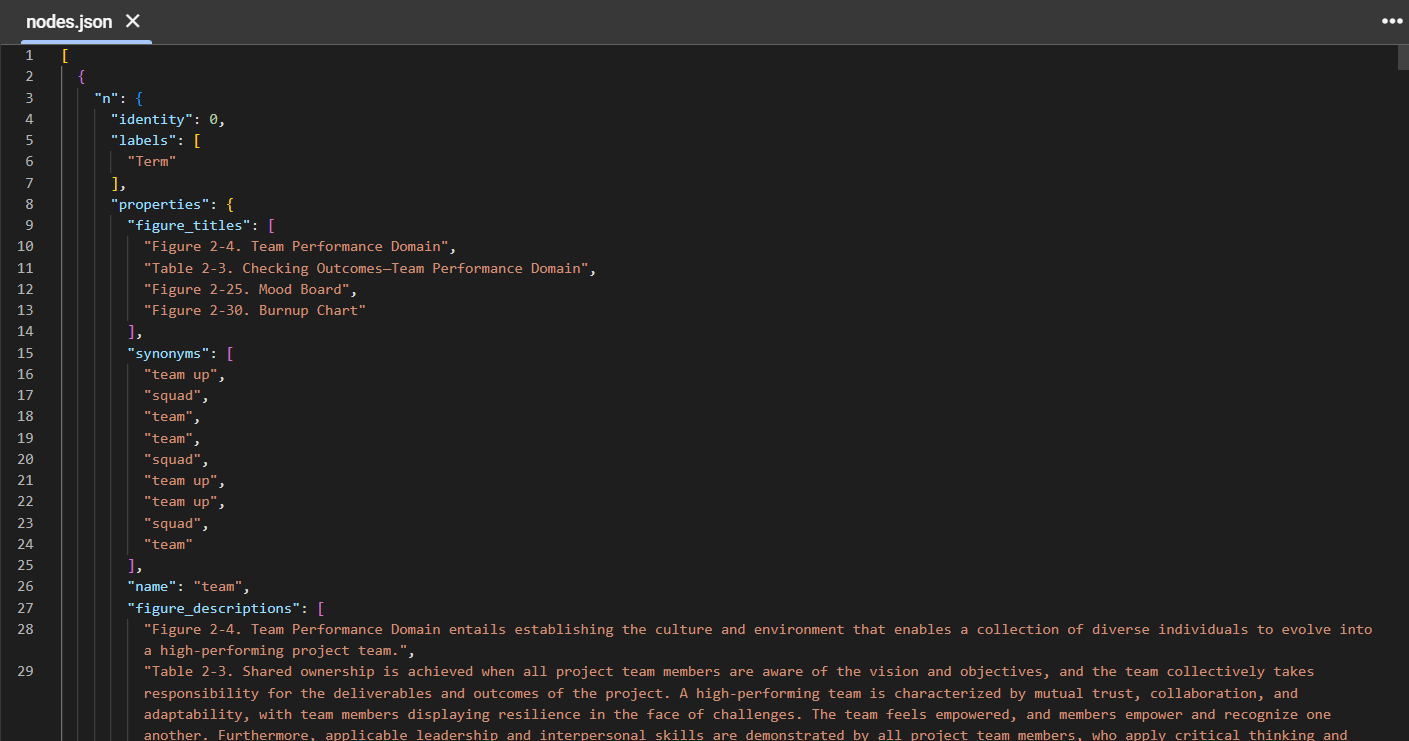

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import json

# Define paths to nodes and edges JSON files
nodes_path = '/content/drive/MyDrive/Colab_Data/nodes.json'
edges_path = '/content/drive/MyDrive/Colab_Data/edges.json'

In [ ]:
# Function to load JSON data for nodes and edges
def load_graph_data(nodes_path, edges_path):
    try:
        # Load nodes data from the JSON file
        with open(nodes_path, 'r') as file:
            nodes_data = json.load(file)

        # Load edges data from the JSON file
        with open(edges_path, 'r') as file:
            edges_data = json.load(file)

        return nodes_data, edges_data

    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None, None

# Load the graph data from the JSON files
nodes_data, edges_data = load_graph_data(nodes_path, edges_path)

# Optionally, print the loaded data to verify
if nodes_data and edges_data:
    print("Nodes Data:", nodes_data)
    print("Edges Data:", edges_data)
else:
    print("Failed to load graph data.")


Nodes Data: [{'n': {'identity': 0, 'labels': ['Term'], 'properties': {'figure_titles': ['Figure 2-4. Team Performance Domain', 'Table 2-3. Checking Outcomes—Team Performance Domain', 'Figure 2-25. Mood Board', 'Figure 2-30. Burnup Chart'], 'synonyms': ['team up', 'squad', 'team', 'team', 'squad', 'team up', 'team up', 'squad', 'team'], 'name': 'team', 'figure_descriptions': ['Figure 2-4. Team Performance Domain entails establishing the culture and environment that enables a collection of diverse individuals to evolve into a high-performing project team.', 'Table 2-3. Shared ownership is achieved when all project team members are aware of the vision and objectives, and the team collectively takes responsibility for the deliverables and outcomes of the project. A high-performing team is characterized by mutual trust, collaboration, and adaptability, with team members displaying resilience in the face of challenges. The team feels empowered, and members empower and recognize one another. 

In [ ]:
import torch
from transformers import (
    BertTokenizer, BertModel, BartForConditionalGeneration, BartTokenizer,
    T5ForConditionalGeneration, T5Tokenizer, pipeline
)
from sentence_transformers import SentenceTransformer, util

# Initialize retrieval and generation models and tokenizers
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')  # Better for similarity
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
t5_model = T5ForConditionalGeneration.from_pretrained("t5-base")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Question-answering pipeline for additional context extraction
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Threshold to determine relevance
SIMILARITY_THRESHOLD = 0.5

In [ ]:
# Modify the sample node dictionary preparation
nodes = {}
for node in nodes_data:
    node_id = node["n"]["elementId"]
    # Extracting properties safely using .get()
    nodes[node_id] = {
        'name': node["n"]["properties"].get('name', 'Unknown'),
        'definition': node["n"]["properties"].get('definition', 'No definition available'),
        'synonyms': node["n"]["properties"].get('synonyms', []),  # Default to empty list if missing
        'figure_titles': node["n"]["properties"].get('figure_titles', []),  # Default to empty list if missing
        'figure_descriptions': node["n"]["properties"].get('figure_descriptions', [])  # Default to empty list if missing
    }

In [ ]:
# Function to create embeddings for each node based on 'name', 'definition', and 'figure_descriptions'
def create_node_embeddings(nodes):
    embeddings = []
    node_texts = []

    for node in nodes.values():
        text = node['name'] + " " + (node['definition'] or "")
        if node.get('figure_descriptions'):
            text += " " + " ".join(node['figure_descriptions'])
        node_texts.append(text)

        embedding = bert_model.encode(text, convert_to_tensor=True)
        embeddings.append(embedding)

    return embeddings, node_texts

# Generate embeddings for nodes
node_embeddings, node_texts = create_node_embeddings(nodes)

In [ ]:
# Function to retrieve context based on query and relevance threshold
def retrieve_context(query, node_embeddings, nodes, top_k=5):
    # Encode the query using sentence-transformers for similarity-based retrieval
    query_embedding = bert_model.encode(query, convert_to_tensor=True)

    # Calculate cosine similarities and get top-k matches
    similarities = util.pytorch_cos_sim(query_embedding, torch.stack(node_embeddings))[0]  # Convert list to tensor
    top_k_indices = torch.topk(similarities, k=top_k).indices

    # Filter out results that fall below the similarity threshold
    relevant_nodes = []
    for idx in top_k_indices:
        if similarities[idx] >= SIMILARITY_THRESHOLD:
            relevant_nodes.append(list(nodes.values())[idx])

    if not relevant_nodes:
        return None, None, None, None

    # Gather related topics, definitions, and figure descriptions
    definitions = []
    figure_descriptions = []
    related_topics = []
    for node in relevant_nodes:
        definitions.append(node.get('definition', ""))
        figure_descriptions.extend(node.get('figure_descriptions', []))
        related_topics.append(node['name'])

    # Summarize figure descriptions
    fig_desc_text = " ".join(figure_descriptions)
    inputs = bart_tokenizer.encode(fig_desc_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return " ".join(definitions), summary, related_topics, [node['figure_titles'] for node in relevant_nodes]

In [ ]:
# Function to answer the query based on definitions and summarized figure descriptions
def answer_query(query, definitions, figure_summary, related_topics, context_figures):
    # If no relevant nodes are found, return an out-of-domain response
    if definitions is None:
        return f"Query: '{query}'\n\nI couldn't find relevant information in the domain context."

    # Use question-answering pipeline with definitions as context
    qa_result = qa_pipeline(question=query, context=definitions)
    answer = qa_result['answer']

    # Generate a more detailed explanation with T5
    inputs = t5_tokenizer.encode(f"answer question: {query} context: {definitions}", return_tensors="pt", max_length=512, truncation=True)
    detailed_ids = t5_model.generate(inputs, max_length=100, num_beams=3, early_stopping=True)
    detailed_explanation = t5_tokenizer.decode(detailed_ids[0], skip_special_tokens=True)

    # Build response
    response = f"Query: '{query}'\n\nDefinition:\n{answer}\n"
    response += f"\nDetailed Explanation:\n{figure_summary}\n"
    response += f"\nExtended Response:\n{detailed_explanation}\n"
    response += "\nRelated Topics:\n" + ", ".join(related_topics)
    response += "\nFigures:\n" + ", ".join([fig for figs in context_figures for fig in figs])
    return response


In [ ]:
# Interactive Query Loop
def interactive_query():
    print("Enter your query (or type 'exit' to quit):")
    while True:
        query = input("Your query: ")
        if query.lower() == 'exit':
            break

        definitions, figure_summary, related_topics, context_figures = retrieve_context(query, node_embeddings, nodes)

        response = answer_query(query, definitions, figure_summary, related_topics, context_figures)
        print(response)

# Example usage
interactive_query()


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Enter your query (or type 'exit' to quit):
Your query: what is the role of a project manager ?
Query: 'what is the role of a project manager ?'

Definition:
A systematic approach or procedure for performing a task

Detailed Explanation:
 project management typically applies unique methods and approaches tailored to temporary endeavors, while general management focuses on sustained operational efficiency. Figure 2-2 is a visual listing of diverse project stakeholders, including suppliers, customers, end-users, regulatory bodies, governing bodies, PMOs, steering committees, and the project team. Figure 3-4 is a representation of the process of assessing organizational and project factors when tailoring a project management approach.

Extended Response:
coordinating resources to achieve goals

Related Topics:
management, model, method
Figures:
Figure 3-1. Overlap of Project Management and General Management Principles, Figure 1-1. Relationship between Project Management Principles and Pro

#Evaluation

Evaluating this multi-modal knowledge graph modeling phase involves assessing the quality of both individual components (data retrieval, embedding quality, relevance determination) and the integrated response pipeline (accuracy and relevance of generated responses). After assessing the overall responses to the queries , other evaluation tecniques that will be done in the upcoming steps are:

* Relevance Scoring: Measures the similarity of model responses to predefined ground truth responses.
* Response Coherence: Checks if the responses are complete, structured, and coherent.
* Accuracy in Topic Retrieval: Evaluates if the correct topics or nodes are being retrieved.
* Timing Analysis: Measures the response time for each query to assess model speed.

In [ ]:
import time
from sentence_transformers import SentenceTransformer, util
import torch

In [ ]:
# Predefined ground truth responses for a set of evaluation queries
evaluation_data = {
    "What is project management?": "Project management is the process of leading a team to achieve goals within constraints.",
    "Explain risk management in projects.": "Risk management in projects involves identifying, analyzing, and responding to project risks.",
    "What are the stages in project planning?": "The stages include defining objectives, scheduling tasks, and allocating resources."
}


In [ ]:
# Initialize the evaluation model
bert_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')  # Same model for embeddings


In [ ]:
# Function to evaluate model response relevance
def relevance_score(query, model_response, ground_truth):
    # Encode ground truth and model response
    gt_embedding = bert_model.encode(ground_truth, convert_to_tensor=True)
    response_embedding = bert_model.encode(model_response, convert_to_tensor=True)

    # Calculate cosine similarity
    relevance = util.pytorch_cos_sim(gt_embedding, response_embedding).item()
    return relevance

In [ ]:
# Function to measure response coherence
def response_coherence(response):
    # Basic coherence measure (can be expanded with NLP methods)
    coherence_score = 1.0 if response and response[-1] == '.' else 0.0
    return coherence_score


In [ ]:
# Timing Analysis
response_times = []

# Evaluation Loop
total_relevance = 0
total_coherence = 0
num_queries = len(evaluation_data)

for query, ground_truth in evaluation_data.items():
    # Start timing
    start_time = time.time()

    # Get model response using the defined query retrieval function
    definitions, figure_summary, related_topics, context_figures = retrieve_context(query, node_embeddings, nodes)
    model_response = answer_query(query, definitions, figure_summary, related_topics, context_figures)

    # Calculate response time
    response_time = time.time() - start_time
    response_times.append(response_time)

    # Calculate relevance score
    relevance = relevance_score(query, model_response, ground_truth)
    total_relevance += relevance

    # Calculate coherence score
    coherence = response_coherence(model_response)
    total_coherence += coherence

    # Output results for each query
    print(f"Query: {query}")
    print(f"Model Response: {model_response}")
    print(f"Relevance Score: {relevance:.4f}")
    print(f"Coherence Score: {coherence:.4f}")
    print(f"Response Time: {response_time:.2f} seconds\n")

# Overall Evaluation Metrics
average_relevance = total_relevance / num_queries
average_coherence = total_coherence / num_queries
average_response_time = sum(response_times) / num_queries

print("Overall Evaluation:")
print(f"Average Relevance Score: {average_relevance:.4f}")
print(f"Average Coherence Score: {average_coherence:.4f}")
print(f"Average Response Time: {average_response_time:.2f} seconds")


Query: What is project management?
Model Response: Query: 'What is project management?'

Definition:
planning, organizing, and coordinating resources to achieve goals

Detailed Explanation:
Project management typically applies unique methods and approaches tailored to temporary endeavors, while general management focuses on sustained operational efficiency. Figure 2-2 is a visual listing of diverse project stakeholders, including suppliers, customers, end-users, regulatory bodies, governing bodies, PMOs, steering committees, and the project team. Table 4-3 is a mapping of artifacts likely to be used in each performance domain.

Extended Response:
process of planning, organizing, and coordinating resources to achieve goals

Related Topics:
management, method, model, system, organization
Figures:
Figure 3-1. Overlap of Project Management and General Management Principles, Figure 1-1. Relationship between Project Management Principles and Project Performance Domains, Figure 2-2. Examples 

The overall scores are good just the coherence score is due to the structure of the message being separated into sections
